# Retail Demo Store - Personalization Workshop - Lab 1
Welcome to the Retail Demo Store Personalization Workshop. In this module we're going to be implementing multiple personalization use cases, powered by Amazon Personalize (https://aws.amazon.com/personalize/), to enhance the base Retail Demo Store storefront. We will break up the process into multiple labs that are designed to progressively build on top of each other. Therefore, you should complete the labs in the order specified below. Some labs are optional, as indicated below.

## Workshop overview
### Core/required labs
The following labs guide you step-by-step through building the core personalization capabilities used in the Retail Demo Store storefront as well as foundational components leveraged in other workshops such as experimentation, messaging, and conversational.

Lab 1: Introduction and dataset preparation (this lab) (25 minutes)
Lab 2: Prepare Amazon Personalize and import datasets (20 minutes)
Lab 3: Create e-commerce domain recommenders and custom solutions in Amazon Personalize (60 minutes)
Lab 4: Evaluate recommendations from Amazon Personalize recommenders and campaigns, activate real-time events using an Event Tracker, and apply business rules using filters (30-40 minutes)
### Optional labs
The following labs allow you to further explore how to pair Amazon Personalize with popular customer data platforms (CDPs); using Personalize for user segementation; and alternative use cases such as personalized offers.

Real-time events with CDPs
Lab 5: Segment real-time data (optional) (45 minutes)
Lab 6: mParticle (optional) (45 minutes)
Lab 7: Intelligent user segmentation using Amazon Personalize (20-30 minutes)
Lab 8: Personalized offers (optional) (120 minutes)
### Cleanup
The cleanup lab will tear down all of the Personalize resources created by the labs in this workshop.

Lab 9: Cleanup resources (15 minutes)
## Overview of use cases
Through the labs in the workshop we will be adding personalization to several views in the Retail Demo Store.

Navigation:
Personalized search: the order of search results displayed in the auto-complete search dropdown are personalized to each user's interests.
Home page:
Recommended For You: the "Inspired by your shopping trends" grid is populated with personalized recommendations for the current user (if emulating a shopper or after a few interactions have been collected for a cold user).
Featured products personalized ranking: order featured products based on the current user's interests.
Product detail:
Related product recommendations: the "Compare similar items" carousel is populated with related item recommendations based on co-interactions of other items and thematic similarities between items.
Category detail:
Personalized ranking: the order of items displayed on the category detail pages are personalized to the current user's interests.
Interactive video stream:
Related product recommendations: the "Compare similar items" carousel is populated with related item recommendations based on co-interactions of other items and thematic similarities between items.
In addition, the recommenders we build in this workshop will be foundational components of other Retail Demo Store workshops including the customer messaging workshop, conversational AI workshop, and location services workshop.

## Introduction to Amazon Personalize
Amazon Personalize makes it easy for customers to develop applications with a wide array of personalization use cases, including real time product recommendations and customized direct marketing. Amazon Personalize brings the same machine learning technology used by Amazon.com to everyone for use in their applications – with no machine learning experience required. Amazon Personalize customers pay for what they use, with no minimum fees or upfront commitment. You can start using Amazon Personalize with a simple three step process, which only takes a few clicks in the AWS console, or a set of simple API calls. First, point Amazon Personalize to user data, catalog data, and activity stream of views, clicks, purchases, etc. in Amazon S3 or upload using a simple API call. Second, with a single click in the console or an API call, train a custom private recommendation model for your data. Third, retrieve personalized recommendations for any user by creating a recommender or campaign, and using the GetRecommendations API.

In this lab we are going to focus on inspecting and preparing the data we will need to provide to Personalize.

## Setup
The workshop will be using the python programming language and the AWS SDK for python. Even if you are not fluent in python, the code cells should be reasonably intuitive. In practice, you can use any programming language supported by the AWS SDK to complete the same steps from this workshop in your application environment.

### Update dependencies
To get started, we need to perform a bit of setup. First, we need to ensure that a current version of botocore is locally installed. The botocore library is used by boto3, the AWS SDK library for python. We need a current version to be able to access some of the newer Amazon Personalize features.

The following cell will update pip and install the latest botocore library.

In [1]:
import sys
!{sys.executable} -m pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 3.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 22.2.1
    Uninstalling pip-22.2.1:
      Successfully uninstalled pip-22.2.1


In [2]:
!{sys.executable} -m pip install --upgrade --no-deps --force-reinstall botcore


  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for botcore, since package 'wheel' is not installed.
  Running setup.py install for botcore ... done


### Import dependencies
Next we need to import some dependencies/libraries needed to complete this lab.

In [4]:
!{sys.executable} pip install notebook_utils

/bin/bash: {sys.executable}: command not found


In [31]:
import boto3
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import requests
import csv
import os
#import notebook_util

%matplotlib inline

### Create cients
Next we need to create the AWS service clients needed for this workshop.

- personalize: this client is used to create resources in Amazon Personalize
- servicediscovery: this client is used to lookup the local IP addresses of the Retail Demo Store microservices that we'll need in the workshop
- ssm: this client is used to access application configuration details stored in the Systems Manager parameter store

Finally we'll lookup an identifier, stored as a resource tag in the SageMaker instance at deployment time. We need this tag to lookup resources we need, such as the IAM role needed by Personalize

In [32]:
# Setuo clients
personalize = boto3.client('personalize')
servicediscovery = boto3.client('servicediscovery')
ssm = boto3.client('ssm')

#Uid = notebook_util.lookup_uid()
# assert Uid is not None, 'Uid could not be determined from notebook instance tags'
# print('Uid:', Uid)


In [6]:
print(personalize)

### Lookup S3 bucket and initialize file names
We will be configuring some variables that will store the location of our source data. When the Retail Demo Store stack was deployed in this account, an Amazon S3 bucket was created for you and the name of this bucket was stored in Systems Manager Parameter Store. Using the ssm boto3 client we created above, we can retrieve the name of the bucket.

In [33]:
import pprint
bucketresponse = ssm.get_parameter(
    Name='retaildemostore-stack-bucket'
)
print(f'bucketresponse:\n{bucketresponse}')

print('---------')
pprint.pprint(ssm.describe_parameters())
print('---------')

# We will use this bucket to store our training data:
bucket = bucketresponse['Parameter']['Value']

# We will build and upload our training data in these files:
items_filename = 'items.csv'
users_filename = 'users.csv'
interactions_filename = 'interactions.csv'

print('Bucket: {}'.format(bucket))


bucketresponse:
{'Parameter': {'Name': 'retaildemostore-stack-bucket', 'Type': 'String', 'Value': 'retaildemostore-base-13eysyuyzzk00-bu-stackbucket-js42fft30ghd', 'Version': 1, 'LastModifiedDate': datetime.datetime(2022, 8, 29, 18, 10, 11, 339000, tzinfo=tzlocal()), 'ARN': 'arn:aws:ssm:us-east-1:016882278218:parameter/retaildemostore-stack-bucket', 'DataType': 'text'}, 'ResponseMetadata': {'RequestId': '4c09e40b-b1b1-4112-a98c-635fc16b2f4e', 'HTTPStatusCode': 200, 'HTTPHeaders': {'server': 'Server', 'date': 'Fri, 09 Sep 2022 10:26:35 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '290', 'connection': 'keep-alive', 'x-amzn-requestid': '4c09e40b-b1b1-4112-a98c-635fc16b2f4e'}, 'RetryAttempts': 0}}
---------
{'NextToken': 'AAEAAa0V4Kc2ZlY3/EtMgM1D/N9K2DYCJgSrHjB+E5Q9K+pdAAAAAGMbFNs4Te1ZhQVE1NlyE4wc2lEB+6liixZP04ruMPMrIGWuuUexO6WtZN+5/mlmMyxTI46UiD2aFzocqqbctSTU8UpzoZ287Ux5b7lcwReuXVumJMZrt7cV7wrHwb3EC5/45wL6aPVJQhhqsZ0/nVMW/PjVVsHfXlikv9Ii3Bjdk8Wbxam53iGODqvtTeKRQg3

## Fetch, Prepare, and Upload User, Product, and Interaction Data
Amazon Personalize provides predefined recipes, based on common use cases, for training models. A recipe is a machine learning algorithm that you use with settings, or hyperparameters, and the data you provide to train an Amazon Personalize model. The data you provide to train a model are organized into separate datasets by the type of data being provided. A collection of datasets are organized into a dataset group. The three dataset types supported by Personalize are items, users, and interactions. Depending on the recipe type you choose, a different combination of dataset types are required. For all recipe types, an interactions dataset is required. Interactions represent how users interact with items. For example, viewing a product, watching a video, listening to a recording, or reading an article. For this workshop, we will be using a recipes that supports all three dataset types.

When we deployed the Retail Demo Store, it was deployed with an initial seed of fictitious User and Product data. We will use this data to train multiple models (recommenders and solutions) in the Amazon Personalize service which will be used to serve product recommendations, related items, and to rerank product lists for our users. The User and Product data can be accessed from the Retail Demo Store's Users and Products microservices, respectively. We will access our data through microservice data APIs, process the data, and upload them as CSVs to S3. Once our datasets are in S3, we can import them into the Amazon Personalize service.

Let's get started.

### Get Products Service Instance
We will be pulling our Product data from the Products Service (https://github.com/aws-samples/retail-demo-store/tree/master/src/products) that was deployed in Amazon Elastic Container Service as part of the Retail Demo Store. To connect to this service we will use AWS Cloud Map's Service Discovery (https://aws.amazon.com/cloud-map/) to discover an instance of the Product Service running in ECS, and then connect directly to that service instances to access our data.

In [34]:
response = servicediscovery.discover_instances(
    NamespaceName='retaildemostore.local',
    ServiceName='products',
    MaxResults=1,
    HealthStatus='HEALTHY'
)

print('---------')
pprint.pprint(response)
print('---------')

assert len(response['Instances']) > 0, 'Products service instance not found; check ECS to ensure it launched cleanly'

products_service_instance = response['Instances'][0]['Attributes']['AWS_INSTANCE_IPV4']
print('Products Service Instance IP: {}'.format(products_service_instance))


---------
{'Instances': [{'Attributes': {'AVAILABILITY_ZONE': 'us-east-1b',
                               'AWS_INIT_HEALTH_STATUS': 'HEALTHY',
                               'AWS_INSTANCE_IPV4': '10.215.20.126',
                               'AWS_INSTANCE_PORT': '80',
                               'ECS_CLUSTER_NAME': 'retaildemostore-Base-13EYSYUYZZK00-ECSCluster-1UJR76NTPQDGE',
                               'ECS_SERVICE_NAME': 'retaildemostore-Services-12NF7MRGVY872-ProductsService-17UJT5E9V4T93-Service-4XUADBA0GPN-FargateService-6RsTB9IQ7zSo',
                               'ECS_TASK_DEFINITION_FAMILY': 'retaildemostore-Services-12NF7MRGVY872-ProductsService-17UJT5E9V4T93-Service-4XUADBA0GPN-retaildemostore',
                               'REGION': 'us-east-1'},
                'HealthStatus': 'HEALTHY',
                'InstanceId': 'b2b20261815c4c9c86d9fc43eb2f4855',
                'NamespaceName': 'retaildemostore.local',
                'ServiceName': 'products'}],
 'Respon

### Download and Explore the Products Dataset
Next, let's call the Products service to fetch all products in the catalog and then load that product information into a Pandas dataframe. Once in a dataframe, we can display, inspect, and manipulate data as needed. A snapshot of the dataframe is displayed to give you an idea of the fields available in the catalog for each product.

In [36]:
products_service_instance_public = '3.210.183.19' # when stop the task after run IP different
response = requests.get('http://{}/products/all'.format(products_service_instance_public),timeout=10)
products = response.json()
products_df = pd.DataFrame(products)
pd.set_option('display.max_rows', 5)
products_df


,id,url,sk,name,category,style,description,aliases,price,image,gender_affinity,current_stock,featured
0,e1669081-8ffc-4dec-97a6-e9176d7f6651,http://d2dqg31qmn6qjz.cloudfront.net/#/product...,,Sans Pareil Scarf,apparel,scarf,Sans pareil scarf for women,None,124.99,http://d2dqg31qmn6qjz.cloudfront.net/images/ap...,F,12,NaN
1,cfafd627-7d6b-43a5-be05-4c7937be417d,http://d2dqg31qmn6qjz.cloudfront.net/#/product...,,Chef Knife,housewares,kitchen,A must-have for your kitchen,None,57.99,http://d2dqg31qmn6qjz.cloudfront.net/images/ho...,NaN,9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463,12f93a36-e282-4445-92ae-356eb6a560fd,http://d2dqg31qmn6qjz.cloudfront.net/#/product...,,Roses Arrangement,floral,arrangement,Roses arrangement grown sustainably on our org...,None,98.99,http://d2dqg31qmn6qjz.cloudfront.net/images/fl...,NaN,19,NaN
2464,23e77743-ff28-400a-811f-e08d3cab5e45,http://d2dqg31qmn6qjz.cloudfront.net/#/product...,,Ultrachic Scarf,apparel,scarf,Ultrachic scarf for women for every occasion,None,123.99,http://d2dqg31qmn6qjz.cloudfront.net/images/ap...,F,7,NaN


In [ ]:
# From ECS Clusters->Tasks->Task : 5b7951ca76384157b3a1cfc4fcf9eb10 ( retaildemostore-Services-12NF7MRGVY872-ProductsService-17UJT5E9V4T93-Service-4XUADBA0GPN-retaildemostore:2)
# https://us-east-1.console.aws.amazon.com/ecs/home?region=us-east-1#/clusters/retaildemostore-Base-13EYSYUYZZK00-ECSCluster-1UJR76NTPQDGE/tasks/5b7951ca76384157b3a1cfc4fcf9eb10/details
http://10.215.10.228/products/all # private (doesn't work)
http://34.207.138.244/products/all # public

### Prepare items dataset
When training models in Amazon Personalize, we can provide structured and unstructured metadata about our items. This data helps improve the relevance of recommendations and is particularly useful when recommending new/cold items added to your catalog.

For this workshop we will be using retail domain recommenders for some of our personalization use cases as well as creating some custom solutions for other use cases. The retail domain recommenders were released at re:Invent 2021. You can read more about them in the Personalize blog (https://aws.amazon.com/blogs/machine-learning/amazon-personalize-announces-recommenders-optimized-for-retail-and-media-entertainment/).

The retail domain recommenders stipulate some reserved fields/columns (https://docs.aws.amazon.com/personalize/latest/dg/ECOMMERCE-datasets-and-schemas.html) that we must conform to. For this workshop we will use the price, category, style, description, and gender_affinity fields from the Retail Demo Store catalog add map them to the PRICE, CATEGORY_L1, CATEGORY_L2, PRODUCT_DESCRIPTION, and GENDER columns expected by Personalize. Personalize will automatically apply a natural language processing (NLP) machine learning model to the product description column to extract features from the text. The product's unique identifier is required.

The following cell creates a new dataframe populated with just the columns we intend to use for the items dataset and then renames the columns.

In [156]:
products_dataset_df = products_df[['id','price','category','style','description','gender_affinity']]
products_dataset_df = products_dataset_df.rename(columns={'id':'ITEM_ID',
                                                          'price': 'PRICE',
                                                          'category':'CATEGORY_L1',
                                                          'style':'CATEGORY_L2',
                                                          'description':'PRODUCT_DESCRIPTION',
                                                          'gender_affinity':'GENDER'})
products_dataset_df.head()


,ITEM_ID,PRICE,CATEGORY_L1,CATEGORY_L2,PRODUCT_DESCRIPTION,GENDER
0,e1669081-8ffc-4dec-97a6-e9176d7f6651,124.99,apparel,scarf,Sans pareil scarf for women,F
1,cfafd627-7d6b-43a5-be05-4c7937be417d,57.99,housewares,kitchen,A must-have for your kitchen,NaN
2,6e6ad102-7510-4a02-b8ce-5a0cd6f431d1,133.99,apparel,jacket,This gainsboro jacket for women is perfect for...,F
3,49b89871-5fe7-4898-b99d-953e15fb42b2,196.99,electronics,speaker,High definition speakers to fill the house wit...,NaN
4,5cb18925-3a3c-4867-8f1c-46efd7eba067,9.99,footwear,sandals,This spiffy pair of sandals for woman is perfe...,F


### Inspect items dataset
Let's first get a sense for the dimensions of the item catalog dataframe. The following cell displays the number of rows and columns in the dataframe.

In [157]:
products_dataset_df.shape

(2465, 6)

Now let's make sure that we don't have any missing/null values for each column. Otherwise, Personalize will return an error for columns/fields that it expects to be fully populated. Note that Personalize supports specifying fields that are not fully populated but for the Retail domain recommender fields in the items dataset, all fields for all rows must be fully populated. The following cell will display the list the count of non-null values for each field.

In [158]:
products_dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2465 entries, 0 to 2464
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ITEM_ID              2465 non-null   object 
 1   PRICE                2465 non-null   float64
 2   CATEGORY_L1          2465 non-null   object 
 3   CATEGORY_L2          2465 non-null   object 
 4   PRODUCT_DESCRIPTION  2465 non-null   object 
 5   GENDER               749 non-null    object 
dtypes: float64(1), object(5)
memory usage: 115.7+ KB


In [159]:
products_dataset_df['GENDER'].fillna('Any',inplace=True)

In [160]:
products_dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2465 entries, 0 to 2464
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ITEM_ID              2465 non-null   object 
 1   PRICE                2465 non-null   float64
 2   CATEGORY_L1          2465 non-null   object 
 3   CATEGORY_L2          2465 non-null   object 
 4   PRODUCT_DESCRIPTION  2465 non-null   object 
 5   GENDER               2465 non-null   object 
dtypes: float64(1), object(5)
memory usage: 115.7+ KB


In [161]:
products_dataset_df.head()

,ITEM_ID,PRICE,CATEGORY_L1,CATEGORY_L2,PRODUCT_DESCRIPTION,GENDER
0,e1669081-8ffc-4dec-97a6-e9176d7f6651,124.99,apparel,scarf,Sans pareil scarf for women,F
1,cfafd627-7d6b-43a5-be05-4c7937be417d,57.99,housewares,kitchen,A must-have for your kitchen,Any
2,6e6ad102-7510-4a02-b8ce-5a0cd6f431d1,133.99,apparel,jacket,This gainsboro jacket for women is perfect for...,F
3,49b89871-5fe7-4898-b99d-953e15fb42b2,196.99,electronics,speaker,High definition speakers to fill the house wit...,Any
4,5cb18925-3a3c-4867-8f1c-46efd7eba067,9.99,footwear,sandals,This spiffy pair of sandals for woman is perfe...,F


Our items dataset is now ready. The following cell will save the dataframe to a local CSV file and then upload the CSV to the staging S3 bucket.

In [162]:
products_dataset_df.to_csv(items_filename, index=False)
boto3.Session().resource('s3').Bucket(bucket).Object(items_filename).upload_file(items_filename)

### Get Users Service Instance
Next, let's prepare the users dataset with information on the users pre-loaded into the Retail Detail Store.

We will be pulling our User data from the Users Service (https://github.com/aws-samples/retail-demo-store/tree/master/src/users) that is deployed as part of the Retail Demo Store. To connect to this service we will use Service Discovery to discover an instance of the User Service, and then connect directly to that service instance to access our data.

In [43]:
response = servicediscovery.discover_instances(
    NamespaceName='retaildemostore.local',
    ServiceName='users',
    MaxResults=1,
    HealthStatus='HEALTHY'
)

pprint.pprint(response)

assert len(response['Instances']) > 0, 'Users service instance not found; check ECS to ensure it launched cleanly'

users_service_instance = response['Instances'][0]['Attributes']['AWS_INSTANCE_IPV4']
print(f'users_service_instance: {users_service_instance}')


{'Instances': [{'Attributes': {'AVAILABILITY_ZONE': 'us-east-1b',
                               'AWS_INIT_HEALTH_STATUS': 'HEALTHY',
                               'AWS_INSTANCE_IPV4': '10.215.20.178',
                               'AWS_INSTANCE_PORT': '80',
                               'ECS_CLUSTER_NAME': 'retaildemostore-Base-13EYSYUYZZK00-ECSCluster-1UJR76NTPQDGE',
                               'ECS_SERVICE_NAME': 'retaildemostore-Services-12NF7MRGVY872-UsersService-HKOQX1H52UX5-Service-TDFA3FFSDWZJ-FargateService-68DLpCOYHwQe',
                               'ECS_TASK_DEFINITION_FAMILY': 'retaildemostore-Services-12NF7MRGVY872-UsersService-HKOQX1H52UX5-Service-TDFA3FFSDWZJ-retaildemostore',
                               'REGION': 'us-east-1'},
                'HealthStatus': 'HEALTHY',
                'InstanceId': 'e58cc25f0ca54fdba47c857f1e912a2d',
                'NamespaceName': 'retaildemostore.local',
                'ServiceName': 'users'}],
 'ResponseMetadata': {'HTTP

In [ ]:
# users_service_instance contains private IP, it doesn't work, we need public
# https://us-east-1.console.aws.amazon.com/ecs/home?region=us-east-1#/clusters/retaildemostore-Base-13EYSYUYZZK00-ECSCluster-1UJR76NTPQDGE/tasks/62afa216fe0f46518b41a874a474c701/details
# Private IP 10.215.20.178
# Public IP 3.237.180.163 # after stop/start IP changes

### Download and Explore the Users Dataset
Similar to the Products microservice above, we'll query the Users microservice to retrieve information on all pre-loaded users. Along the way we'll remove all users without a gender or persona (i.e. users added to the storefront after deployment).

In [44]:
users_service_instance_public = '3.237.180.163'
response = requests.get('http://{}/users/all/?count=10000'.format(users_service_instance_public))
users = response.json()
users_df = pd.DataFrame(users)
users_df.head()


,id,username,email,first_name,last_name,addresses,age,gender,persona,discount_persona,selectable_user
0,1,user1,mark.johnson@example.com,Mark,Johnson,"[{'first_name': 'Mark', 'last_name': 'Johnson'...",31,M,furniture_homedecor_housewares,lower_priced_products,True
1,2,user2,kristen.calderon@example.com,Kristen,Calderon,"[{'first_name': 'Kristen', 'last_name': 'Calde...",58,F,tools_housewares_apparel,discount_indifferent,True
2,3,user3,joseph.maddox@example.com,Joseph,Maddox,"[{'first_name': 'Joseph', 'last_name': 'Maddox...",43,M,floral_beauty_jewelry,lower_priced_products,True
3,4,user4,jay.lewis@example.com,Jay,Lewis,"[{'first_name': 'Jay', 'last_name': 'Lewis', '...",38,M,books_apparel_homedecor,discount_indifferent,True
4,5,user5,anthony.valdez@example.com,Anthony,Valdez,"[{'first_name': 'Anthony', 'last_name': 'Valde...",24,M,instruments_books_electronics,discount_indifferent,True


In [45]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5250 entries, 0 to 5249
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                5250 non-null   object
 1   username          5250 non-null   object
 2   email             5250 non-null   object
 3   first_name        5250 non-null   object
 4   last_name         5250 non-null   object
 5   addresses         5250 non-null   object
 6   age               5250 non-null   int64 
 7   gender            5250 non-null   object
 8   persona           5250 non-null   object
 9   discount_persona  5250 non-null   object
 10  selectable_user   5250 non-null   bool  
dtypes: bool(1), int64(1), object(9)
memory usage: 415.4+ KB


In [50]:
#users_df.nunique()

In [46]:
# my test userId = 3748
users_df[users_df['username'] == 'user3748']

,id,username,email,first_name,last_name,addresses,age,gender,persona,discount_persona,selectable_user
3747,3748,user3748,hannah.underwood@example.com,Hannah,Underwood,"[{'first_name': 'Hannah', 'last_name': 'Underw...",32,F,floral_beauty_jewelry,discount_indifferent,True


In [47]:
# check users which we are going to remove in the next block
users_df[(users_df['persona'].str.strip().astype(bool) == False) | (users_df['gender'].str.strip().astype(bool) == False)]


,id,username,email,first_name,last_name,addresses,age,gender,persona,discount_persona,selectable_user


In [48]:
# Remove any users without a persona or gender (i.e. possibly created in web UI)
print(users_df.shape)
users_df = users_df[(users_df['persona'].str.strip().astype(bool)) | (users_df['gender'])]
print(users_df.shape)
pd.set_option('display.max_rows',5)
users_df

(5250, 11)
(5250, 11)


,id,username,email,first_name,last_name,addresses,age,gender,persona,discount_persona,selectable_user
0,1,user1,mark.johnson@example.com,Mark,Johnson,"[{'first_name': 'Mark', 'last_name': 'Johnson'...",31,M,furniture_homedecor_housewares,lower_priced_products,True
1,2,user2,kristen.calderon@example.com,Kristen,Calderon,"[{'first_name': 'Kristen', 'last_name': 'Calde...",58,F,tools_housewares_apparel,discount_indifferent,True
...,...,...,...,...,...,...,...,...,...,...,...
5248,5249,user5249,vincent.wells@example.com,Vincent,Wells,"[{'first_name': 'Vincent', 'last_name': 'Wells...",33,M,housewares_floral_seasonal,discount_indifferent,True
5249,5250,user5250,monica.garcia@example.com,Monica,Garcia,"[{'first_name': 'Monica', 'last_name': 'Garcia...",34,F,housewares_tools_beauty,discount_indifferent,True


### Prepare and Upload Data
Similar to the items dataset we created above, we can provide metadata on our users when training models in Personalize. For this workshop we will include each user's age and gender. Unlike the columns in the items dataset, there are no column naming requirements for the users dataset (https://docs.aws.amazon.com/personalize/latest/dg/ECOMMERCE-users-dataset.html). As before, we will use uppercase column names to match the Personalize convention, save the data as a CSV, and upload to our S3 bucket.

In [52]:
users_dataset_df = users_df[['id','age','gender']] # if we don't use persona column why we deleted rows where they are absent?
users_dataset_df = users_dataset_df.rename(columns = {'id':'USER_ID','age':'AGE','gender':'GENDER'})

users_dataset_df.to_csv(users_filename, index=False)
boto3.Session().resource('s3').Bucket(bucket).Object(users_filename).upload_file(users_filename)



### Create User-Items Interactions Dataset
To mimic user behavior, we will be using a pre-generted dataset that represents user interactions with items. To make the interactions more realistic, a pre-defined shopper persona is used for each user to generate event types for products matching that persona. The interactions dataset contains for viewing products, adding products to a cart, checking out, and completing orders. The effect of discounts on interactions depends on a separate "discount persona" stored against the user.

For more information about how interactions dataset was generated, take a look at the script file at generate_interactions_personalize.py.

Don't worry about understanding the nuances of the generator script. In a production workload you'd be using actual user interactions from your clickstream analytics and order managemement systems rather than generating them as we've done for this demo.

First, let's download the pre-generated interactions CSV from the S3 bucket used to deploy the Retail Demo Store project in your account.

In [4]:
# the following doesn't work for me: can't install notebook_util, no info anywhere
# generated interaction.csv manually with '(AWS) Retail Demo Store - Generate Users Interactions Dataset'

s3 = boto3.resource('s3')

resource_bucket, resource_path = notebook_util.lookup_resource_bucket_and_path()
assert resource_bucket is not None, 'Resource bucket could not be determined from notebook instance tags'
print(f'Resource bucket: {resource_bucket}')
print(f'Resource path: {resource_path}')

print('Downloading pre-generated interactions.csv')
s3.Bucket(resource_bucket).download_file(resource_path + 'csvs/interactions.csv', interactions_filename)


NameError: name 'notebook_util' is not defined

### Open and Explore the Simulated Interactions Dataset
Let's take a closer look at the generated interactions file. First let us see a few lines of the raw CSV data:

In [7]:
!head -n 5 $interactions_filename

head: $interactions_filename: No such file or directory


Now let us load it as a Pandas dataframe. Note:

An EVENT_TYPE column which can be used to train different Personalize campaigns and also to filter on recommendations.
The custom DISCOUNT column which is a contextual metadata field, that Personalize reranking campaign and user personalization recommenders can take into account to predict on the best next product based the user's propensity to interact with discount products.

In [168]:
interactions_filename = '/Users/Andrew/Desktop/(AWS) Retail Demo Store/interactions.csv'
interactions_df = pd.read_csv(interactions_filename)
interactions_df = interactions_df.astype({'ITEM_ID':str,'USER_ID':str,'EVENT_TYPE':str,'TIMESTAMP':int,'DISCOUNT':str})
interactions_df.head()


,ITEM_ID,USER_ID,EVENT_TYPE,TIMESTAMP,DISCOUNT
0,b93b7b15-9bb3-407c-b80b-517e7c45e090,3156,View,1654034407,No
1,b93b7b15-9bb3-407c-b80b-517e7c45e090,3156,View,1654034412,No
2,3946f4c8-1b5b-4161-b794-70b33affb671,2122,View,1654034430,No
3,3946f4c8-1b5b-4161-b794-70b33affb671,2122,View,1654034440,No
4,e9daa7cd-8230-4544-9f07-86fa84d7c3c1,2485,View,1654034450,No


In [169]:
interactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675004 entries, 0 to 675003
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ITEM_ID     675004 non-null  object
 1   USER_ID     675004 non-null  object
 2   EVENT_TYPE  675004 non-null  object
 3   TIMESTAMP   675004 non-null  int64 
 4   DISCOUNT    675004 non-null  object
dtypes: int64(1), object(4)
memory usage: 25.7+ MB


In [170]:
interactions_df.dtypes

ITEM_ID       object
USER_ID       object
EVENT_TYPE    object
TIMESTAMP      int64
DISCOUNT      object
dtype: object

In [171]:
interactions_df.groupby(by='EVENT_TYPE').agg({'TIMESTAMP':'count'}).sort_values(by='TIMESTAMP',ascending=False)

,TIMESTAMP
EVENT_TYPE,
View,581900
AddToCart,46552
ViewCart,29095
StartCheckout,11638
Purchase,5819


Chart the counts of each EVENT_TYPE generated for the interactions dataset. We're simulating a site where visitors heavily view/browse products and to a lesser degree add products to their cart and checkout.

                                ITEM_ID USER_ID EVENT_TYPE DISCOUNT
0  b93b7b15-9bb3-407c-b80b-517e7c45e090    3156       View       No
1  b93b7b15-9bb3-407c-b80b-517e7c45e090    3156       View       No
2  3946f4c8-1b5b-4161-b794-70b33affb671    2122       View       No
3  3946f4c8-1b5b-4161-b794-70b33affb671    2122       View       No
4  e9daa7cd-8230-4544-9f07-86fa84d7c3c1    2485       View       No


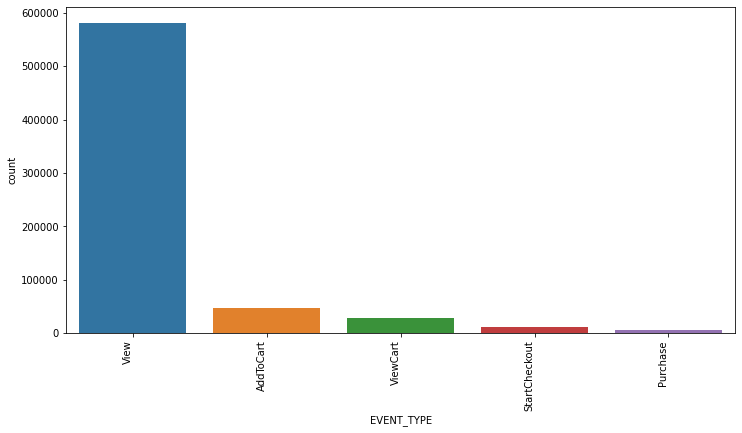

In [172]:
categorical_attributes = interactions_df.select_dtypes(include=['object'])
print(categorical_attributes.head())
plt.figure(figsize=(12,6))
chart = sns.countplot(data=categorical_attributes, x = 'EVENT_TYPE')
plt.xticks(rotation=90,horizontalalignment='right')
plt.show()

Let us plot product persona vs product category distribution - so that you can see what categories get assigned to which types of persona. Note that because of attempts to reach balance between categories and products in the generation script, the proportions do not exactly match those configured.

In [173]:
merged_df = interactions_df[['USER_ID','ITEM_ID']].astype({'USER_ID':str, 'ITEM_ID':str})
merged_df = merged_df.merge(users_df[['id','persona']], left_on='USER_ID',right_on='id').drop(columns=['id','USER_ID'])
merged_df = merged_df.merge(products_df[['id','category']],left_on='ITEM_ID',right_on='id').drop(columns=['id','ITEM_ID'])
print(merged_df.head())

                   persona category
0  housewares_tools_beauty    tools
1  housewares_tools_beauty    tools
2  housewares_tools_beauty    tools
3  housewares_tools_beauty    tools
4  housewares_tools_beauty    tools


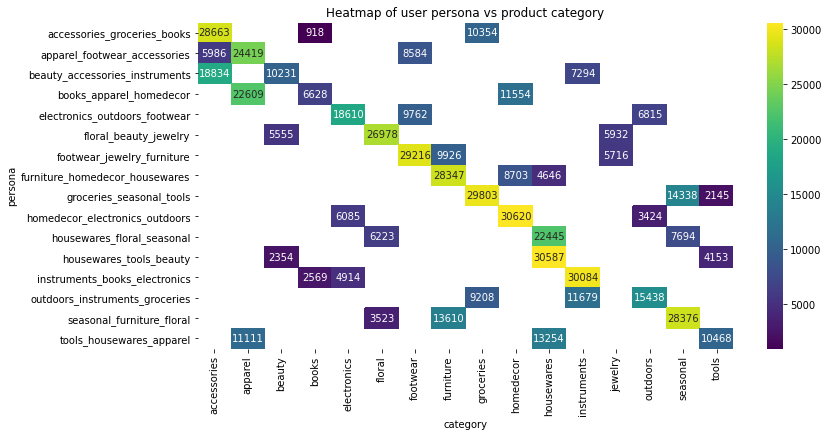

In [174]:
plot_df = merged_df.groupby(by=['persona','category'])['category'].count().unstack()
#print(plot_df)
plt.figure(figsize=(12,6))
sns.heatmap(plot_df, annot=True,fmt='g',cmap='viridis')
plt.title('Heatmap of user persona vs product category')
plt.show()

### Discount persona vs event type distribution
Let us see how the event distribution came out. We should see a different takeup of discounts between users with different discount personas.

        discount_persona DISCOUNT     id
0          all_discounts       No   7153
1          all_discounts      Yes   7373
2   discount_indifferent       No  11491
3   discount_indifferent      Yes   2904
4  lower_priced_products       No   8566
DISCOUNT                  No   Yes
discount_persona                  
all_discounts           7153  7373
discount_indifferent   11491  2904
lower_priced_products   8566  5987


Text(0.5, 1.0, 'Event types according to discount persona')

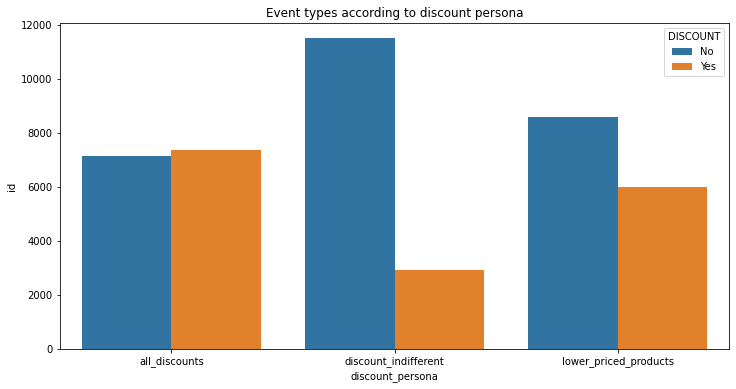

In [175]:
merged_df = interactions_df.loc[interactions_df['EVENT_TYPE'] == 'AddToCart'][['USER_ID','DISCOUNT']]
merged_df = merged_df[['USER_ID','DISCOUNT']].astype({'USER_ID':str}).merge(users_df,left_on='USER_ID',right_on='id')
#merged_df.head()

plot_df_stacked = merged_df.groupby(by=['discount_persona','DISCOUNT'])[['id']].count().reset_index()
print(plot_df_stacked.head())
plot_df_unstacked = merged_df.groupby(by=['discount_persona','DISCOUNT'])[['id']].count().unstack()
plot_df_unstacked = plot_df_unstacked.droplevel(axis='columns',level=0)
print(plot_df_unstacked.head())

plt.figure(figsize=(12,6))
sns.barplot(x='discount_persona', y='id',hue='DISCOUNT',data=plot_df_stacked)
plt.title('Event types according to discount persona')




In [97]:
# check if number of users in each discount_persona category is balanced

users_df.head()
users_df.groupby(by='discount_persona').agg({'id':['count',pd.Series.nunique]})

id        
                      count nunique
discount_persona                   
all_discounts          1750    1750
discount_indifferent   1731    1731
lower_priced_products  1769    1769

### Balance over products I
Let us have a careful look at product and category distributions. The interactions generation script ensures that there are small groups of products users tend to interact with, to maintain strong training signals. If you look at the script you will see that although we choose products randomly within a category, they are interacted with in small random groups in the category.

USER_ID  category  
1        furniture     {485457cd-3e31-4ddc-bb09-e9bb9f151d19, dd8299a...
         homedecor     {669b328d-0905-4a3f-b95d-79c8eb83482f, 21a1420...
         housewares    {510a7e24-88e0-4581-aeb4-a49022da37ce, e41db00...
2        apparel       {5414abd6-a246-4e44-83d9-0ca413290ab0, 79fc3af...
         housewares    {8b892d2c-4b84-410f-a053-086eb46eb5f8, cfafd62...
Name: id, dtype: object
USER_ID  category  
1        furniture     5
         homedecor     3
         housewares    3
2        apparel       4
         housewares    5
Name: id, dtype: int64
<bound method NDFrame.head of 1    1855
2    1687
3    2226
4    3825
5    7811
Name: id, dtype: int64>


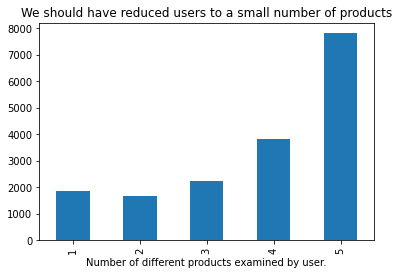

In [110]:
merged_df = interactions_df[['ITEM_ID','USER_ID']].astype({'ITEM_ID':str}).merge(products_df,left_on='ITEM_ID',right_on='id')
plot_df = merged_df.groupby(by=['USER_ID','category']).id.apply(set)
#plot_df = merged_df.groupby(by=['USER_ID','category']).agg({'id':set})
print(plot_df.head())
plot_df = plot_df.apply(len)
#plot_df = plot_df['id'].agg({'id':len})
print(plot_df.head())
plot_df = plot_df.value_counts().sort_index()
print(plot_df.head)
plot_df.plot.bar()
plt.xlabel('Number of different products examined by user.')
plt.title('We should have reduced users to a small number of products')
plt.show()


In [128]:
# the same calculations but simpler
# we need to find for each user and each product category with how many unique ids there were interactions
plot_df1 = merged_df.groupby(by=['USER_ID','category']).agg({'id':pd.Series.nunique})
print(plot_df1.head())
#plot_df1 = plot_df1['id'].apply(len)
plot_df1 = plot_df1.groupby(by='id').agg({'id':'count'})
print(plot_df1.head())


                    id
USER_ID category      
1       furniture    5
        homedecor    3
        housewares   3
2       apparel      4
        housewares   5
      id
id      
1   1855
2   1687
3   2226
4   3825
5   7811
Int64Index([1, 2, 3, 4, 5], dtype='int64', name='id')


### Prepare and Upload Data
Finally, let's upload the generated interactions CSV to S3 so it can be picked up by Amazon Personalize later in the workshop.

In [176]:
interactions_filename = 'interactions.csv'
interactions_df.to_csv(interactions_filename, index=False)
boto3.Session().resource('s3').Bucket(bucket).Object(interactions_filename).upload_file(interactions_filename)


### Lab 1 Summary - What have we accomplished?
In this lab we prepared and inspected the three dataset types (items, users, and interactions) that will be used to train models and create recommenders in Amazon Personalize.

We created a CSV for each dataset type and uploaded them to the Amazon S3 staging bucket created by the Retail Demo Store deployment.

In the next lab we will start creating resources in Amazon Personalize to receive our dataset files.

### Store variables needed in the next lab
We will pass some variables initialized in this lab by storing them in the notebook environment.

In [133]:
%store Uid
%store bucket
%store items_filename
%store users_filename
%store interactions_filename

UsageError: Unknown variable 'Uid'


# Retail Demo Store - Personalization Workshop - Lab 2
In this lab we are going to build on the prior lab by preparing an Amazon Personalize dataset group and importing our three datasets.

## Lab 2 Objectives
In this lab we will accomplish the following steps.

- Create schema resources in Amazon Personalize that define the layout of our three dataset files (CSVs) created in the prior lab
- Create a dataset group in Amazon Personalize that will be used to receive our datasets
- Create a dataset in the Personalize dataset group for the three dataset types and schemas
Items: information about the products in the Retail Demo Store
Users: information about the users in the Retail Deme Store
Interactions: user-item interactions representing typical storefront behavior such as viewing products, adding products to a shopping cart, purchasing products, and so on
- Create dataset import jobs to import each of the three datasets into Personalize

## Setup
Just as in the first lab, we have to prepare our environment by importing dependencies and creating clients.

### Import dependencies
The following libraries are needed for this lab.

In [135]:
import boto3
import json
import uuid
import time
from botocore.exceptions import ClientError

### Create clients
We will need the following AWS service clients in this lab.

In [136]:
personalize = boto3.client('personalize')

### Load variables saved in Lab 1
At the end of Lab 1 we saved some variables that we'll need in this lab. The following cell will load those variables into this lab environment.

In [137]:
%store -r

## Configure Amazon Personalize
Now that we've prepared our three datasets and uploaded them to S3 we'll need to configure the Amazon Personalize service to understand our data so that it can be used to train models for generating recommendations.

Note: if you deployed the Retail Demo Store with the "auto create Personalize resources" flag set to "Yes", the following steps have already been automatically completed for you.

### Create Schemas for Datasets
Amazon Personalize requires a schema for each dataset so it can map the columns in our CSVs to fields for model training. Each schema is declared in JSON using the Apache Avro format.

Let's define and create schemas in Personalize for our datasets.

Note that categorical fields include an additional attribute of "categorical": true and the textual field has an additional attribute of "textual": true. Categorical fields are those where one or more values can be specified for the field value (i.e. enumerated values). For example, one or more category names/codes for the CATEGORY_L1 field. A textual field indicates that Personalize should apply a natural language processing (NLP) model to the field's value to extract model features from unstructured text. In this case, we're using the product description as the textual field. You can only have one textual field in the items dataset.

Another detail to note is that when we call the CreateSchema API, we pass an optional domain parameter with a value of ECOMMERCE. This tells Personalize that we are creating a schema for Retail/E-commerce domain. We will do this for all three schemas.

### Items Datsaset Schema

In [141]:
items_schema = {
    'type':'record',
    'name': 'Items',
    'namespace': 'com.amazonaws.personalize.schema',
    'fields':[
        {
            'name':'ITEM_ID',
            'type':'string'
        },
        {
            'name':'PRICE',
            'type':'float'
        },
        {
            'name':'CATEGORY_L1',
            'type':'string',
            'categorical': True
        },
        {
            'name':'CATEGORY_L2',
            'type':'string',
            'categorical':True
        },
        {
            'name':'PRODUCT_DESCRIPTION',
            'type':'string',
            'textual':True
        },
        {
            'name':'GENDER',
            'type':'string',
            'categorical':True
        },
    ],
    'version':'1.0'
}

try:
    create_schema_response = personalize.create_schema(
        name = 'retaildemostore-products-items',
        domain = 'ECOMMERCE',
        schema = json.dumps(items_schema)
    )
    items_schema_arn = create_schema_response['schemaArn']
    print(json.dumps(create_schema_response, indent=2))
except personalize.exceptions.ResourceAlreadyExistsException:
    print('You aready created this schema, seemingly')
    paginator = personalize.get_paginator('list_schemas')
    for paginate_result in paginator.paginate():
        for schema in paginate_result['schemas']:
            if schema['name'] == 'retaildemostore-products-items':
                items_schema_arn = schema['schemaArn']
                print(f"Using existing schema: {items_schema_arn}")
                break

{
  "schemaArn": "arn:aws:personalize:us-east-1:016882278218:schema/retaildemostore-products-items",
  "ResponseMetadata": {
    "RequestId": "291533d3-88a3-4bdd-a1fb-0cbf7dda7adc",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Tue, 13 Sep 2022 08:39:32 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "96",
      "connection": "keep-alive",
      "x-amzn-requestid": "291533d3-88a3-4bdd-a1fb-0cbf7dda7adc"
    },
    "RetryAttempts": 0
  }
}


### Users Dataset Schema

In [142]:
users_schema = {
    "type": "record",
    "name": "Users",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "AGE",
            "type": "int"
        },
        {
            "name": "GENDER",
            "type": "string",
            "categorical": True,
        }
    ],
    "version": "1.0"
}

try:
    create_schema_response = personalize.create_schema(
        name = "retaildemostore-products-users",
        domain = "ECOMMERCE",
        schema = json.dumps(users_schema)
    )
    print(json.dumps(create_schema_response, indent=2))
    users_schema_arn = create_schema_response['schemaArn']
except personalize.exceptions.ResourceAlreadyExistsException:
    print('You aready created this schema, seemingly')
    paginator = personalize.get_paginator('list_schemas')
    for paginate_result in paginator.paginate():
        for schema in paginate_result['schemas']:
            if schema['name'] == 'retaildemostore-products-users':
                users_schema_arn = schema['schemaArn']
                print(f"Using existing schema: {users_schema_arn}")
                break

{
  "schemaArn": "arn:aws:personalize:us-east-1:016882278218:schema/retaildemostore-products-users",
  "ResponseMetadata": {
    "RequestId": "81911851-57f5-49d1-b6e5-53f5dd9d888b",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Tue, 13 Sep 2022 08:42:46 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "96",
      "connection": "keep-alive",
      "x-amzn-requestid": "81911851-57f5-49d1-b6e5-53f5dd9d888b"
    },
    "RetryAttempts": 0
  }
}


### Interactions Dataset Schema

In [143]:
interactions_schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "EVENT_TYPE",  # "View", "Purchase", etc.
            "type": "string"
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        },
        {
            "name": "DISCOUNT",  # This is the contextual metadata - "Yes" or "No".
            "type": "string"
        },
    ],
    "version": "1.0"
}

try:
    create_schema_response = personalize.create_schema(
        name = "retaildemostore-products-interactions",
        domain = "ECOMMERCE",
        schema = json.dumps(interactions_schema)
    )
    print(json.dumps(create_schema_response, indent=2))
    interactions_schema_arn = create_schema_response['schemaArn']
except personalize.exceptions.ResourceAlreadyExistsException:
    print('You aready created this schema, seemingly')
    paginator = personalize.get_paginator('list_schemas')
    for paginate_result in paginator.paginate():
        for schema in paginate_result['schemas']:
            if schema['name'] == 'retaildemostore-products-interactions':
                interactions_schema_arn = schema['schemaArn']
                print(f"Using existing schema: {interactions_schema_arn}")
                break

{
  "schemaArn": "arn:aws:personalize:us-east-1:016882278218:schema/retaildemostore-products-interactions",
  "ResponseMetadata": {
    "RequestId": "58515cc9-3009-4ce5-a2af-1643489af6f6",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Tue, 13 Sep 2022 08:43:20 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "103",
      "connection": "keep-alive",
      "x-amzn-requestid": "58515cc9-3009-4ce5-a2af-1643489af6f6"
    },
    "RetryAttempts": 0
  }
}


### Create and Wait for Dataset Group
Next we need to create the dataset group that will contain our three datasets. This is one of many Personalize operations that are asynchronous. That is, we call an API to create a resource and have to wait for it to become active.

#### Create Dataset Group
Note that we are also passing ECOMMERCE for the domain parameter here too.

In [144]:
try:
    create_dataset_group_response = personalize.create_dataset_group(
        name = 'retaildemostore-products',
        domain = 'ECOMMERCE'
    )
    dataset_group_arn = create_dataset_group_response['datasetGroupArn']
    print(json.dumps(create_dataset_group_response, indent=2))
except personalize.exceptions.ResourceAlreadyExistsException:
    print('You aready created this dataset group, seemingly')
    paginator = personalize.get_paginator('list_dataset_groups')
    for paginate_result in paginator.paginate():
        for dataset_group in paginate_result['datasetGroups']:
            if dataset_group['name'] == 'retaildemostore-products':
                dataset_group_arn = dataset_group['datasetGroupArn']
                break
                
print(f'DatasetGroupArn = {dataset_group_arn}')

{
  "datasetGroupArn": "arn:aws:personalize:us-east-1:016882278218:dataset-group/retaildemostore-products",
  "domain": "ECOMMERCE",
  "ResponseMetadata": {
    "RequestId": "64b16dc4-38aa-4cfb-a371-32778159bf58",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Tue, 13 Sep 2022 08:49:10 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "124",
      "connection": "keep-alive",
      "x-amzn-requestid": "64b16dc4-38aa-4cfb-a371-32778159bf58"
    },
    "RetryAttempts": 0
  }
}
DatasetGroupArn = arn:aws:personalize:us-east-1:016882278218:dataset-group/retaildemostore-products


#### Wait for Dataset Group to Have ACTIVE Status

In [145]:
status = None
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_group_response = personalize.describe_dataset_group(
        datasetGroupArn = dataset_group_arn
    )
    status = describe_dataset_group_response["datasetGroup"]["status"]
    print("DatasetGroup: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(15)

DatasetGroup: ACTIVE


### Create Items Dataset
Next we will create the datasets in Personalize for our three dataset types. Let's start with the items dataset.

In [146]:
try:
    dataset_type = "ITEMS"
    create_dataset_response = personalize.create_dataset(
        name = "retaildemostore-products-items",
        datasetType = dataset_type,
        datasetGroupArn = dataset_group_arn,
        schemaArn = items_schema_arn
    )

    items_dataset_arn = create_dataset_response['datasetArn']
    print(json.dumps(create_dataset_response, indent=2))
except personalize.exceptions.ResourceAlreadyExistsException:
    print('You aready created this dataset, seemingly')
    paginator = personalize.get_paginator('list_datasets')
    for paginate_result in paginator.paginate(datasetGroupArn = dataset_group_arn):
        for dataset in paginate_result['datasets']:
            if dataset['name'] == 'retaildemostore-products-items':
                items_dataset_arn = dataset['datasetArn']
                break
                
print(f'Items dataset ARN = {items_dataset_arn}')

{
  "datasetArn": "arn:aws:personalize:us-east-1:016882278218:dataset/retaildemostore-products/ITEMS",
  "ResponseMetadata": {
    "RequestId": "28ecba82-27d6-4e0d-a2bc-1f4948205200",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Tue, 13 Sep 2022 08:57:16 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "98",
      "connection": "keep-alive",
      "x-amzn-requestid": "28ecba82-27d6-4e0d-a2bc-1f4948205200"
    },
    "RetryAttempts": 0
  }
}
Items dataset ARN = arn:aws:personalize:us-east-1:016882278218:dataset/retaildemostore-products/ITEMS


### Create Users Dataset


In [147]:
try:
    dataset_type = "USERS"
    create_dataset_response = personalize.create_dataset(
        name = "retaildemostore-products-users",
        datasetType = dataset_type,
        datasetGroupArn = dataset_group_arn,
        schemaArn = users_schema_arn
    )

    users_dataset_arn = create_dataset_response['datasetArn']
    print(json.dumps(create_dataset_response, indent=2))
except personalize.exceptions.ResourceAlreadyExistsException:
    print('You aready created this dataset, seemingly')
    paginator = personalize.get_paginator('list_datasets')
    for paginate_result in paginator.paginate(datasetGroupArn = dataset_group_arn):
        for dataset in paginate_result['datasets']:
            if dataset['name'] == 'retaildemostore-products-users':
                users_dataset_arn = dataset['datasetArn']
                break
                
print(f'Users dataset ARN = {users_dataset_arn}')

{
  "datasetArn": "arn:aws:personalize:us-east-1:016882278218:dataset/retaildemostore-products/USERS",
  "ResponseMetadata": {
    "RequestId": "c05450b2-5d5f-4b52-b6d9-a987eed4f344",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Tue, 13 Sep 2022 08:57:47 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "98",
      "connection": "keep-alive",
      "x-amzn-requestid": "c05450b2-5d5f-4b52-b6d9-a987eed4f344"
    },
    "RetryAttempts": 0
  }
}
Users dataset ARN = arn:aws:personalize:us-east-1:016882278218:dataset/retaildemostore-products/USERS


### Create Interactions Dataset

In [148]:
try:
    dataset_type = "INTERACTIONS"
    create_dataset_response = personalize.create_dataset(
        name = "retaildemostore-products-interactions",
        datasetType = dataset_type,
        datasetGroupArn = dataset_group_arn,
        schemaArn = interactions_schema_arn
    )

    interactions_dataset_arn = create_dataset_response['datasetArn']
    print(json.dumps(create_dataset_response, indent=2))
except personalize.exceptions.ResourceAlreadyExistsException:
    print('You aready created this dataset, seemingly')
    paginator = personalize.get_paginator('list_datasets')
    for paginate_result in paginator.paginate(datasetGroupArn = dataset_group_arn):
        for dataset in paginate_result['datasets']:
            if dataset['name'] == 'retaildemostore-products-interactions':
                interactions_dataset_arn = dataset['datasetArn']
                break
                
print(f'Interactions dataset ARN = {interactions_dataset_arn}')

{
  "datasetArn": "arn:aws:personalize:us-east-1:016882278218:dataset/retaildemostore-products/INTERACTIONS",
  "ResponseMetadata": {
    "RequestId": "fe24e448-1010-42df-ad85-aceedf88177d",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Tue, 13 Sep 2022 08:58:23 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "105",
      "connection": "keep-alive",
      "x-amzn-requestid": "fe24e448-1010-42df-ad85-aceedf88177d"
    },
    "RetryAttempts": 0
  }
}
Interactions dataset ARN = arn:aws:personalize:us-east-1:016882278218:dataset/retaildemostore-products/INTERACTIONS


### Wait for datasets to become active
It can take a minute or two for the datasets to be created. Let's wait for all three to become active.

In [149]:
%%time

dataset_arns = [ items_dataset_arn, users_dataset_arn, interactions_dataset_arn ]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for dataset_arn in reversed(dataset_arns):
        response = personalize.describe_dataset(
            datasetArn = dataset_arn
        )
        status = response["dataset"]["status"]

        if status == "ACTIVE":
            print(f'Dataset {dataset_arn} successfully completed')
            dataset_arns.remove(dataset_arn)
        elif status == "CREATE FAILED":
            print(f'Dataset {dataset_arn} failed')
            if response['dataset'].get('failureReason'):
                print('   Reason: ' + response['dataset']['failureReason'])
            dataset_arns.remove(dataset_arn)

    if len(dataset_arns) > 0:
        print('At least one dataset is still in progress')
        time.sleep(15)
    else:
        print("All datasets have completed")
        break

Dataset arn:aws:personalize:us-east-1:016882278218:dataset/retaildemostore-products/INTERACTIONS successfully completed
Dataset arn:aws:personalize:us-east-1:016882278218:dataset/retaildemostore-products/USERS successfully completed
Dataset arn:aws:personalize:us-east-1:016882278218:dataset/retaildemostore-products/ITEMS successfully completed
All datasets have completed
CPU times: user 38.7 ms, sys: 18.8 ms, total: 57.5 ms
Wall time: 1.24 s


### Import Datasets to Personalize
In Lab 1 we generated CSVs containing bulk data for our users, items, and interactions and staged them in an S3 bucket. So far in this Lab we have created schemas in Personalize that define the columns in our CSVs. Then we created a datset group and three datasets in Personalize that will receive our data. In the following steps we will create import jobs with Personalize that will import the datasets from our S3 bucket into the service.

## Inspect permissions
By default, the Personalize service does not have permission to acccess the data we uploaded into the S3 bucket in our account. In order to grant access to the Personalize service to read our CSVs, we need to set a Bucket Policy and create an IAM role that the Amazon Personalize service will assume.

The deployment process for the Retail Demo Store has already setup these resources for you. However, let's take a look at the bucket policy and IAM role to see the required permissions.

We'll start by displaying the bucket policy in the S3 staging bucket where we uploaded the CSVs.

In [150]:
s3 = boto3.client('s3')
response = s3.get_bucket_policy(Bucket = bucket)
print(json.dumps(json.loads(response['Policy']), indent=2))

{
  "Version": "2012-10-17",
  "Statement": [
    {
      "Effect": "Deny",
      "Principal": "*",
      "Action": "s3:*",
      "Resource": [
        "arn:aws:s3:::retaildemostore-base-13eysyuyzzk00-bu-stackbucket-js42fft30ghd",
        "arn:aws:s3:::retaildemostore-base-13eysyuyzzk00-bu-stackbucket-js42fft30ghd/*"
      ],
      "Condition": {
        "Bool": {
          "aws:SecureTransport": "false"
        }
      }
    },
    {
      "Effect": "Allow",
      "Principal": {
        "Service": "personalize.amazonaws.com"
      },
      "Action": [
        "s3:GetObject",
        "s3:PutObject",
        "s3:ListBucket"
      ],
      "Resource": [
        "arn:aws:s3:::retaildemostore-base-13eysyuyzzk00-bu-stackbucket-js42fft30ghd",
        "arn:aws:s3:::retaildemostore-base-13eysyuyzzk00-bu-stackbucket-js42fft30ghd/*"
      ]
    }
  ]
}


In the bucket policy above you will see that there are two policy statements. The first statement denies all S3 actions that are not made using secure transport. This statement is not required for Personalize access since it already uses secure transport but it is included as a security best practice. The second statement is where access is granted to Personalize. Note the service principal of personalize.amazonaws.com and the actions allowed on the staging bucket. The s3:GetObject is needed for import jobs to allow Personalize to read objects from the bucket and the s3:PutObject is used for export jobs, batch inference jobs, and batch segment jobs to allow Personalize to write output files to the bucket. The s3:ListBucket action allows Personalize to list the contents of a folder.

Next, let's look at the IAM role that Personalize will need to assume to access the S3 bucket. Again, this role was created for you during the Retail Demo Store deployment. We'll start by inspecting the role itself.

In [152]:
iam = boto3.client("iam")

Uid = 'retaildemostore-us-east-1' # couldn't get in the lab 1 because no module notebook_utils

role_name = Uid+"-PersonalizeS3"

response = iam.get_role(RoleName = role_name)
role_arn = response['Role']['Arn']
print(json.dumps(response['Role'], indent=2, default = str))

{
  "Path": "/",
  "RoleName": "retaildemostore-us-east-1-PersonalizeS3",
  "RoleId": "AROAQH3SDD5FNWMUCL3AD",
  "Arn": "arn:aws:iam::016882278218:role/retaildemostore-us-east-1-PersonalizeS3",
  "CreateDate": "2022-08-29 16:09:38+00:00",
  "AssumeRolePolicyDocument": {
    "Version": "2012-10-17",
    "Statement": [
      {
        "Effect": "Allow",
        "Principal": {
          "Service": "personalize.amazonaws.com"
        },
        "Action": "sts:AssumeRole"
      }
    ]
  },
  "Description": "",
  "MaxSessionDuration": 3600,
  "RoleLastUsed": {}
}


### Create Import Jobs
With the permissions in place to allow Personalize to access our CSV files, let's create three import jobs to import each file into its respective dataset. Each import job can take several minutes to complete so we'll create all three import jobs and then wait for them all to complete. This allows them to import in parallel.

#### Create Items Dataset Import Job

In [165]:
str(uuid.uuid4())[:8]

'3f032526'

In [163]:
import_job_suffix = str(uuid.uuid4())[:8]

items_create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "retaildemostore-products-items-" + import_job_suffix,
    datasetArn = items_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, items_filename)
    },
    roleArn = role_arn
)

items_dataset_import_job_arn = items_create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(items_create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-east-1:016882278218:dataset-import-job/retaildemostore-products-items-d56f1e45",
  "ResponseMetadata": {
    "RequestId": "21865eed-1d2a-4d2f-92ad-bdd9aa1a86a3",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Tue, 13 Sep 2022 09:38:51 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "127",
      "connection": "keep-alive",
      "x-amzn-requestid": "21865eed-1d2a-4d2f-92ad-bdd9aa1a86a3"
    },
    "RetryAttempts": 0
  }
}


#### Create Users Dataset Import Job

In [166]:
users_create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "retaildemostore-products-users-" + import_job_suffix,
    datasetArn = users_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, users_filename)
    },
    roleArn = role_arn
)

users_dataset_import_job_arn = users_create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(users_create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-east-1:016882278218:dataset-import-job/retaildemostore-products-users-d56f1e45",
  "ResponseMetadata": {
    "RequestId": "279d87a0-1344-4728-8e6c-24e8045d7192",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Tue, 13 Sep 2022 09:50:41 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "127",
      "connection": "keep-alive",
      "x-amzn-requestid": "279d87a0-1344-4728-8e6c-24e8045d7192"
    },
    "RetryAttempts": 0
  }
}


#### Create Interactions Dataset Import Job

In [177]:
interactions_create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "retaildemostore-products-interactions-" + import_job_suffix,
    datasetArn = interactions_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, interactions_filename)
    },
    roleArn = role_arn
)

interactions_dataset_import_job_arn = interactions_create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(interactions_create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-east-1:016882278218:dataset-import-job/retaildemostore-products-interactions-d56f1e45",
  "ResponseMetadata": {
    "RequestId": "731b1617-d12e-476d-92be-093dc332cbb2",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Tue, 13 Sep 2022 10:09:55 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "134",
      "connection": "keep-alive",
      "x-amzn-requestid": "731b1617-d12e-476d-92be-093dc332cbb2"
    },
    "RetryAttempts": 0
  }
}


### Wait for Import Jobs to Complete
It will take 10-15 minutes for the import jobs to complete, while you're waiting you can learn more about Datasets and Schemas here: https://docs.aws.amazon.com/personalize/latest/dg/how-it-works-dataset-schema.html

We will wait for all three jobs to finish.

### Wait for Items Import Job to Complete

In [178]:
%%time

import_job_arns = [ items_dataset_import_job_arn, users_dataset_import_job_arn, interactions_dataset_import_job_arn ]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for job_arn in reversed(import_job_arns):
        import_job_response = personalize.describe_dataset_import_job(
            datasetImportJobArn = job_arn
        )
        status = import_job_response["datasetImportJob"]['status']

        if status == "ACTIVE":
            print(f'Import job {job_arn} successfully completed')
            import_job_arns.remove(job_arn)
        elif status == "CREATE FAILED":
            print(f'Import job {job_arn} failed')
            if import_job_response["datasetImportJob"].get('failureReason'):
                print('   Reason: ' + import_job_response["datasetImportJob"]['failureReason'])
            import_job_arns.remove(job_arn)

    if len(import_job_arns) > 0:
        print('At least one dataset import job still in progress')
        time.sleep(60)
    else:
        print("All import jobs have ended")
        break

Import job arn:aws:personalize:us-east-1:016882278218:dataset-import-job/retaildemostore-products-interactions-d56f1e45 successfully completed
Import job arn:aws:personalize:us-east-1:016882278218:dataset-import-job/retaildemostore-products-users-d56f1e45 successfully completed
Import job arn:aws:personalize:us-east-1:016882278218:dataset-import-job/retaildemostore-products-items-d56f1e45 successfully completed
All import jobs have ended
CPU times: user 31.4 ms, sys: 7.82 ms, total: 39.3 ms
Wall time: 1.26 s


## Lab 2 Summary - What have we accomplished?
In this lab we created schemas in Amazon Personalize that mapped to the dataset CSVs we created in Lab 1. We also created a dataset group in Personalize as well as datasets to receive our CSVs. Since Personalize needs access to the staging S3 bucket where the CSVs were uploaded, we inspected the S3 bucket policy and IAM role that needs to be passed to Personalize. Finally, we create dataset import jobs in Personalize to upload the three datasets into Personalize.

In the next lab we will create the recommenders and custom solutions and solution versions for our personalization use cases. This is where the machine learning models are trained and deployed.

### Store variables needed in the next lab
We will pass some variables initialized in this lab by storing them in the notebook environment.

In [179]:
%store dataset_group_arn
%store role_arn

Stored 'dataset_group_arn' (str)
Stored 'role_arn' (str)


## Retail Demo Store - Personalization Workshop - Lab 3
In this lab we are going to build on the prior lab by creating Amazon Personalize domain recommenders and custom solutions for additional use cases.

### Lab 3 Objectives
In this lab we will accomplish the following steps.

- Create retail domain recommenders for the following use cases:
 - Recommended For You: will be used on the homepage (and other later workshops) to provide personalized recommendations for a given user. This recommender will be used for known users or warm anonymous users.
 - Popular Items by Views: will be used on the homepage for new/cold anonymous users where no interaction history is available. Once a new/cold user has a few interactions (product views), the homepage will switch to the Recommended For You recommender.
- Create custom solutions and solution versions for the following use cases:
 - Similar Items: will be used on the product detail and "live" pages to display similar items to a given item.
 - Personalized-Ranking: will be used to rerank featured products and search results.
 - Item Attribute Affinity: user segmentation model that will be used in a later lab.

### Setup
Just as in the previous labs, we have to prepare our environment by importing dependencies and creating clients.

#### Import dependencies
The following libraries are needed for this lab.

In [ ]:
import boto3
import json
import time
from botocore.exceptions import ClientError


### Create clients
We will need the following AWS service clients in this lab.

In [180]:
personalize = boto3.client('personalize')

### Load variables saved in prior labs
At the end of Lab 1 we saved some variables that we'll need in this lab. The following cell will load those variables into this lab environment.

In [181]:
%store -r

### Create Recommenders
With our three datasets imported into our dataset group, we can now turn to creating recommenders and solutions. We'll start with pre-configured recommenders that match some of our core use cases.

Let's start by listing the recipes for the ECOMMERCE domain. From these recipes we will be creating the following three recommenders.

- Recommended For You - will be used on the home page for the "Inspired by your shopping trends" grid.
- Popular Items By Views - will be used on the home page for new/cold users with no interactions so we can bootstrap the user experience with popular products. Once the user is "warm", we will switch to the Recommended For You recommender.

In [184]:
response = personalize.list_recipes(domain = 'ECOMMERCE')
print(json.dumps(response['recipes'], indent=2, default=str))


[
  {
    "name": "aws-ecomm-customers-who-viewed-x-also-viewed",
    "recipeArn": "arn:aws:personalize:::recipe/aws-ecomm-customers-who-viewed-x-also-viewed",
    "status": "ACTIVE",
    "creationDateTime": "2019-06-10 02:00:00+02:00",
    "lastUpdatedDateTime": "2022-08-17 02:25:42.935000+02:00",
    "domain": "ECOMMERCE"
  },
  {
    "name": "aws-ecomm-frequently-bought-together",
    "recipeArn": "arn:aws:personalize:::recipe/aws-ecomm-frequently-bought-together",
    "status": "ACTIVE",
    "creationDateTime": "2019-06-10 02:00:00+02:00",
    "lastUpdatedDateTime": "2022-08-17 02:25:42.935000+02:00",
    "domain": "ECOMMERCE"
  },
  {
    "name": "aws-ecomm-popular-items-by-purchases",
    "recipeArn": "arn:aws:personalize:::recipe/aws-ecomm-popular-items-by-purchases",
    "status": "ACTIVE",
    "creationDateTime": "2019-06-10 02:00:00+02:00",
    "lastUpdatedDateTime": "2022-08-17 02:25:42.935000+02:00",
    "domain": "ECOMMERCE"
  },
  {
    "name": "aws-ecomm-popular-items-by

In [185]:
try:
    response = personalize.create_recommender(
      name = 'retaildemostore-recommended-for-you',
      recipeArn = 'arn:aws:personalize:::recipe/aws-ecomm-recommended-for-you',
      datasetGroupArn = dataset_group_arn
    )
    rfy_recommender_arn = response['recommenderArn']
    print(json.dumps(response, indent=2))
except personalize.exceptions.ResourceAlreadyExistsException:
    print('You aready created this recommender, seemingly')
    paginator = personalize.get_paginator('list_recommenders')
    for paginate_result in paginator.paginate(datasetGroupArn = dataset_group_arn):
        for recommender in paginate_result['recommenders']:
            if recommender['name'] == 'retaildemostore-recommended-for-you':
                rfy_recommender_arn = recommender['recommenderArn']
                break
                
print(f'Recommended For You recommender ARN = {rfy_recommender_arn}')

{
  "recommenderArn": "arn:aws:personalize:us-east-1:016882278218:recommender/retaildemostore-recommended-for-you",
  "ResponseMetadata": {
    "RequestId": "2b520709-f365-4f45-ae59-341509fa9cdd",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Tue, 13 Sep 2022 12:19:07 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "111",
      "connection": "keep-alive",
      "x-amzn-requestid": "2b520709-f365-4f45-ae59-341509fa9cdd"
    },
    "RetryAttempts": 0
  }
}
Recommended For You recommender ARN = arn:aws:personalize:us-east-1:016882278218:recommender/retaildemostore-recommended-for-you


### Create Popular Items By Views recommender

In [186]:
try:
    response = personalize.create_recommender(
      name = 'retaildemostore-popular-items',
      recipeArn = 'arn:aws:personalize:::recipe/aws-ecomm-popular-items-by-views',
      datasetGroupArn = dataset_group_arn
    )
    most_viewed_recommender_arn = response['recommenderArn']
    print(json.dumps(response, indent=2))
except personalize.exceptions.ResourceAlreadyExistsException:
    print('You aready created this recommender, seemingly')
    paginator = personalize.get_paginator('list_recommenders')
    for paginate_result in paginator.paginate(datasetGroupArn = dataset_group_arn):
        for recommender in paginate_result['recommenders']:
            if recommender['name'] == 'retaildemostore-popular-items':
                most_viewed_recommender_arn = recommender['recommenderArn']
                break
                
print(f'Most Viewed recommender ARN = {most_viewed_recommender_arn}')

{
  "recommenderArn": "arn:aws:personalize:us-east-1:016882278218:recommender/retaildemostore-popular-items",
  "ResponseMetadata": {
    "RequestId": "0516cb84-f687-43b6-8ea1-6052e89c71c1",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Tue, 13 Sep 2022 12:20:11 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "105",
      "connection": "keep-alive",
      "x-amzn-requestid": "0516cb84-f687-43b6-8ea1-6052e89c71c1"
    },
    "RetryAttempts": 0
  }
}
Most Viewed recommender ARN = arn:aws:personalize:us-east-1:016882278218:recommender/retaildemostore-popular-items


## Create Custom Solutions
The recommenders created above do not cover all of the personalization use cases that we want to implement in the Retail Demo Store. We also want to provide related items recommendations on the product detail page, personalize the order of featured products displayed on the home page, and we want to personalize the search results returned from Open Search in the search widget. To implement these use cases, we will create a custom solution using the Similar-Items (https://docs.aws.amazon.com/personalize/latest/dg/native-recipe-similar-items.html) and Personalized-Ranking recipes (https://docs.aws.amazon.com/personalize/latest/dg/native-recipe-search.html).

In addition, we also want to use Personalize to create user segments based on user affinity with specific product attributes. We'll explore this is a later lab but let's go ahead and create a custom solution using the Item-Attribute-Affinity (https://docs.aws.amazon.com/personalize/latest/dg/item-attribute-affinity-recipe.html) recipe.

These custom solutions will use the same datasets that we already implemented so all we need to do is create a solution and solution version for each recipe.

### List Recipes
First, let's list all available recipes that aren't associated with a domain.

In [222]:
response = personalize.list_recipes()
#print(json.dumps(response, indent=2,default=str))
custom_recipes = []
for recipe in response['recipes']:
    if not recipe.get('domain'):
        custom_recipes.append(recipe)
        
print(json.dumps(custom_recipes, indent=2, default=str))
        


[
  {
    "name": "aws-item-affinity",
    "recipeArn": "arn:aws:personalize:::recipe/aws-item-affinity",
    "status": "ACTIVE",
    "creationDateTime": "2021-07-15 02:00:00+02:00",
    "lastUpdatedDateTime": "2022-08-17 02:25:42.935000+02:00"
  },
  {
    "name": "aws-item-attribute-affinity",
    "recipeArn": "arn:aws:personalize:::recipe/aws-item-attribute-affinity",
    "status": "ACTIVE",
    "creationDateTime": "2021-08-25 02:00:00+02:00",
    "lastUpdatedDateTime": "2022-08-17 02:25:42.935000+02:00"
  },
  {
    "name": "aws-personalized-ranking",
    "recipeArn": "arn:aws:personalize:::recipe/aws-personalized-ranking",
    "status": "ACTIVE",
    "creationDateTime": "2019-06-10 02:00:00+02:00",
    "lastUpdatedDateTime": "2022-08-17 02:25:42.935000+02:00"
  },
  {
    "name": "aws-popularity-count",
    "recipeArn": "arn:aws:personalize:::recipe/aws-popularity-count",
    "status": "ACTIVE",
    "creationDateTime": "2019-06-10 02:00:00+02:00",
    "lastUpdatedDateTime": "2022-

As you can see above, there are several recipes to choose from. Let's declare the recipes for the two custom solutions we will have to create.

### Declare Personalize Recipe for Similar Items
In use-cases where we have an item/product and we want to display similar items based on the co-interactions of all users as well as draw upon thematic similarities based on item metadata, we can use the Similar-Items (https://docs.aws.amazon.com/personalize/latest/dg/native-recipe-similar-items.html) recipe to provided related items recommendations.

The Similar-Items (aws-similar-items) generates recommendations for items that are similar to an item you specify. Similar-Items is optimized for similar item recommendation scenarios with item metadata. To use Similar-Items, you must create an Interactions dataset and an Items dataset. Use Similar-Items when your catalog has item metadata and items with little to no interactions, but your Interactions dataset still has at minimum 1000 unique historical and event interactions (combined).

Similar-Items calculates similarity based on both the co-occurrence of the item in user histories in your Interaction dataset, and the item metadata, including categorical and unstructured text metadata, in your Items dataset. For example, with Similar-Items Amazon Personalize could recommend items customers frequently bought together with a similar style, or movies that different users also watched with a similar description.

Note that Personalize also has the SIMS (https://docs.aws.amazon.com/personalize/latest/dg/native-recipe-sims.html) recipe for the related items use case. However, SIMS only trains on co-interaction data (i.e. the interactions dataset) and does not consider item metadata. Since we may have some items with fewer (or no) interactions, the Similar-Items recipe is a better match for the Retail Demo Store.

In [193]:
similar_items_recipe_arn = 'arn:aws:personalize:::recipe/aws-similar-items'

### Declare Personalize Recipe for Personalized Ranking
In use-cases where we have a curated list of products, we can use the Personalized-Ranking (https://docs.aws.amazon.com/personalize/latest/dg/native-recipe-search.html) recipe to reorder the products for the current user.

The Personalized-Ranking recipe generates personalized rankings. A personalized ranking is a list of recommended items that are re-ranked for a specific user.

In [194]:
ranking_recipe_arn = 'arn:aws:personalize:::recipe/aws-personalized-ranking'


### Declare Personalize Recipe for Item Attribute Affinity
For the user segmentation use case, we will generate groups of users (segments) with an affinity for specific item attributes. We will explore this use case further in an upcoming lab but for now we will create a custom solution and solution version using the Item-Attribute-Affinity recipe.

The Item-Attribute-Affinity (aws-item-attribute-affinity) recipe is a USER_SEGMENTATION recipe that creates a user segment (group of users) for each item attribute that you specify. Use Item-Attribute-Affinity to learn more about your users and take actions based on their respective user segments.

For example, you might want to create a marketing campaign for your retail application based on user preferences for shoe types in your catalog. Item-Attribute-Affinity would create a user segment for each shoe type based data in your Interactions and Items datasets. You could use this to promote different shoes to different user segments based on the likelihood that they will take an action (for example, click a shoe or purchase a shoe). Other uses might include promoting different movie genres to different users or identifying prospective job applicant based on job type.

In [202]:
item_attribute_affinity_recipe_arn = 'arn:aws:personalize:::recipe/aws-item-attribute-affinity'

### Create Custom Solutions and Solution Versions
With our recipes defined, we can now create our solutions and solution versions.

#### Create Similar Items Solution

In [195]:
similar_items_solution_version_arn = None

try:
    create_solution_response = personalize.create_solution(
        name = "retaildemostore-related-items",
        datasetGroupArn = dataset_group_arn,
        recipeArn = similar_items_recipe_arn
    )

    similar_items_solution_arn = create_solution_response['solutionArn']
    print(json.dumps(create_solution_response, indent=2))
except personalize.exceptions.ResourceAlreadyExistsException:
    print('You aready created this solution, seemingly')
    paginator = personalize.get_paginator('list_solutions')
    for paginate_result in paginator.paginate(datasetGroupArn = dataset_group_arn):
        for solution in paginate_result['solutions']:
            if solution['name'] == 'retaildemostore-related-items':
                similar_items_solution_arn = solution['solutionArn']
                print(f'Similar Items solution ARN = {similar_items_solution_arn}')
                
                response = personalize.list_solution_versions(
                    solutionArn = similar_items_solution_arn,
                    maxResults = 100
                )
                if len(response['solutionVersions']) > 0:
                    similar_items_solution_version_arn = response['solutionVersions'][-1]['solutionVersionArn']
                    print(f'Will use most recent solution version for this solution: {similar_items_solution_version_arn}')
                    
                break

{
  "solutionArn": "arn:aws:personalize:us-east-1:016882278218:solution/retaildemostore-related-items",
  "ResponseMetadata": {
    "RequestId": "1edce6af-ec61-409c-bfd3-361daa43dd4f",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Tue, 13 Sep 2022 13:09:21 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "99",
      "connection": "keep-alive",
      "x-amzn-requestid": "1edce6af-ec61-409c-bfd3-361daa43dd4f"
    },
    "RetryAttempts": 0
  }
}


#### Create Similar Items Solution Version
Next we can create a solution version for the solution. This is where the model is trained for this custom solution.

In [198]:
if not similar_items_solution_version_arn:
    create_solution_version_response = personalize.create_solution_version(
        solutionArn = similar_items_solution_arn
    )

    similar_items_solution_version_arn = create_solution_version_response['solutionVersionArn']
    print(json.dumps(create_solution_version_response, indent=2))
else:
    print(f'Solution version {similar_items_solution_version_arn} already exists; not creating')

{
  "solutionVersionArn": "arn:aws:personalize:us-east-1:016882278218:solution/retaildemostore-related-items/f66c9ed4",
  "ResponseMetadata": {
    "RequestId": "f4d37152-4159-45b8-b398-d7854bf85dd4",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Tue, 13 Sep 2022 13:12:32 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "115",
      "connection": "keep-alive",
      "x-amzn-requestid": "f4d37152-4159-45b8-b398-d7854bf85dd4"
    },
    "RetryAttempts": 0
  }
}


#### Create Personalized Ranking Solution

In [199]:
ranking_solution_version_arn = None

try:
    create_solution_response = personalize.create_solution(
        name = "retaildemostore-personalized-ranking",
        datasetGroupArn = dataset_group_arn,
        recipeArn = ranking_recipe_arn
    )

    ranking_solution_arn = create_solution_response['solutionArn']
    print(json.dumps(create_solution_response, indent=2))
except personalize.exceptions.ResourceAlreadyExistsException:
    print('You aready created this solution, seemingly')
    paginator = personalize.get_paginator('list_solutions')
    for paginate_result in paginator.paginate(datasetGroupArn = dataset_group_arn):
        for solution in paginate_result['solutions']:
            if solution['name'] == 'retaildemostore-personalized-ranking':
                ranking_solution_arn = solution['solutionArn']
                print(f'Ranking solution ARN = {ranking_solution_arn}')
                
                response = personalize.list_solution_versions(
                    solutionArn = ranking_solution_arn,
                    maxResults = 100
                )
                if len(response['solutionVersions']) > 0:
                    ranking_solution_version_arn = response['solutionVersions'][-1]['solutionVersionArn']
                    print(f'Will use most recent solution version for this solution: {ranking_solution_version_arn}')
                    
                break

{
  "solutionArn": "arn:aws:personalize:us-east-1:016882278218:solution/retaildemostore-personalized-ranking",
  "ResponseMetadata": {
    "RequestId": "ae654aac-0db6-44d8-8e80-91a2335fee65",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Tue, 13 Sep 2022 13:13:10 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "106",
      "connection": "keep-alive",
      "x-amzn-requestid": "ae654aac-0db6-44d8-8e80-91a2335fee65"
    },
    "RetryAttempts": 0
  }
}


#### Create Personalized Ranking Solution Version
Next we can create a solution version for the solution. This is where the model is trained for this custom solution.

In [200]:
if not ranking_solution_version_arn:
    create_solution_version_response = personalize.create_solution_version(
        solutionArn = ranking_solution_arn
    )

    ranking_solution_version_arn = create_solution_version_response['solutionVersionArn']
    print(json.dumps(create_solution_version_response, indent=2))
else:
    print(f'Solution version {ranking_solution_version_arn} already exists; not creating')

{
  "solutionVersionArn": "arn:aws:personalize:us-east-1:016882278218:solution/retaildemostore-personalized-ranking/c36bd02a",
  "ResponseMetadata": {
    "RequestId": "055d4125-e321-48ee-bfd0-335f29c5a8c1",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Tue, 13 Sep 2022 13:13:49 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "122",
      "connection": "keep-alive",
      "x-amzn-requestid": "055d4125-e321-48ee-bfd0-335f29c5a8c1"
    },
    "RetryAttempts": 0
  }
}


#### Create Item Attribute Affinity Solution

In [203]:
item_attribute_affinity_solution_version_arn = None

try:
    create_solution_response = personalize.create_solution(
        name = "retaildemostore-item-attribute-affinity",
        datasetGroupArn = dataset_group_arn,
        recipeArn = item_attribute_affinity_recipe_arn
    )

    item_attribute_affinity_solution_arn = create_solution_response['solutionArn']
    print(json.dumps(create_solution_response, indent=2))
except personalize.exceptions.ResourceAlreadyExistsException:
    print('You aready created this solution, seemingly')
    paginator = personalize.get_paginator('list_solutions')
    for paginate_result in paginator.paginate(datasetGroupArn = dataset_group_arn):
        for solution in paginate_result['solutions']:
            if solution['name'] == 'retaildemostore-item-attribute-affinity':
                item_attribute_affinity_solution_arn = solution['solutionArn']
                print(f'Item Attribute Affinity solution ARN = {item_attribute_affinity_solution_arn}')
                
                response = personalize.list_solution_versions(
                    solutionArn = item_attribute_affinity_solution_arn,
                    maxResults = 100
                )
                if len(response['solutionVersions']) > 0:
                    item_attribute_affinity_solution_version_arn = response['solutionVersions'][-1]['solutionVersionArn']
                    print(f'Will use most recent solution version for this solution: {item_attribute_affinity_solution_version_arn}')
                    
                break

{
  "solutionArn": "arn:aws:personalize:us-east-1:016882278218:solution/retaildemostore-item-attribute-affinity",
  "ResponseMetadata": {
    "RequestId": "ce55b6b1-931c-42f5-8ce7-e335b75422a6",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Tue, 13 Sep 2022 13:15:56 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "109",
      "connection": "keep-alive",
      "x-amzn-requestid": "ce55b6b1-931c-42f5-8ce7-e335b75422a6"
    },
    "RetryAttempts": 0
  }
}


In [210]:
if not item_attribute_affinity_solution_version_arn:
    create_solution_version_response = personalize.create_solution_version(
        solutionArn = item_attribute_affinity_solution_arn
    )

    item_attribute_affinity_solution_version_arn = create_solution_version_response['solutionVersionArn']
    print(json.dumps(create_solution_version_response, indent=2))
else:
    print(f'Solution version {item_attribute_affinity_solution_version_arn} already exists; not creating')

{
  "solutionVersionArn": "arn:aws:personalize:us-east-1:016882278218:solution/retaildemostore-item-attribute-affinity/5202d82f",
  "ResponseMetadata": {
    "RequestId": "eac91455-6312-4944-9cbf-4caef2882432",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Tue, 13 Sep 2022 14:04:40 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "125",
      "connection": "keep-alive",
      "x-amzn-requestid": "eac91455-6312-4944-9cbf-4caef2882432"
    },
    "RetryAttempts": 0
  }
}


###  Wait for Recommenders and Solution Versions to Complete
It can take 40-60 minutes for all recommenders and solution versions to be created. During this process a model is being trained and tested with the data contained within your datasets. The duration of training jobs can increase based on the size of the dataset, training parameters and a selected recipe. We submitted requests for all three recommenders and two custom solutions and versions at once so they are trained in parallel. In the cells below we will wait for all recommenders and solution versions to finish.

While you are waiting for this process to complete you can learn more about recommenders (https://docs.aws.amazon.com/personalize/latest/dg/creating-recommenders.html) and custom solutions (https://docs.aws.amazon.com/personalize/latest/dg/training-deploying-solutions.html).

The following cell waits for all recommenders to become active.

In [204]:
%%time

recommender_arns = [ rfy_recommender_arn, most_viewed_recommender_arn ]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for recommender_arn in reversed(recommender_arns):
        response = personalize.describe_recommender(
            recommenderArn = recommender_arn
        )
        status = response["recommender"]["status"]

        if status == "ACTIVE":
            print(f'Recommender {recommender_arn} successfully completed')
            recommender_arns.remove(recommender_arn)
        elif status == "CREATE FAILED":
            print(f'Recommender {recommender_arn} failed')
            if response["recommender"].get('failureReason'):
                print('   Reason: ' + response["recommender"]['failureReason'])
            recommender_arns.remove(recommender_arn)

    if len(recommender_arns) > 0:
        print('At least one recommender is still in progress')
        time.sleep(60)
    else:
        print("All recommenders have completed")
        break

Recommender arn:aws:personalize:us-east-1:016882278218:recommender/retaildemostore-popular-items successfully completed
Recommender arn:aws:personalize:us-east-1:016882278218:recommender/retaildemostore-recommended-for-you successfully completed
All recommenders have completed
CPU times: user 35.6 ms, sys: 36.6 ms, total: 72.2 ms
Wall time: 1.15 s


### Wait for custom solution versions to become active
The following cell waits for the solution versions for the similar items, personalized ranking, and item attribute affinity use cases to become active. It's likely that they're already active (or close to being active) since they were being created in parallel with the recommenders. Nevertheless, we'll make sure they are active too before proceeding.

In [213]:
%%time

soln_ver_arns = [ 
    similar_items_solution_version_arn, 
    ranking_solution_version_arn, 
    item_attribute_affinity_solution_version_arn 
]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for soln_ver_arn in reversed(soln_ver_arns):
        soln_ver_response = personalize.describe_solution_version(
            solutionVersionArn = soln_ver_arn
        )
        status = soln_ver_response["solutionVersion"]["status"]

        if status == "ACTIVE":
            print(f'Solution version {soln_ver_arn} successfully completed')
            soln_ver_arns.remove(soln_ver_arn)
        elif status == "CREATE FAILED":
            print(f'Solution version {soln_ver_arn} failed')
            if soln_ver_response["solutionVersion"].get('failureReason'):
                print('   Reason: ' + soln_ver_response["solutionVersion"]['failureReason'])
            soln_ver_arns.remove(soln_ver_arn)

    if len(soln_ver_arns) > 0:
        print('At least one solution version is still in progress')
        time.sleep(60)
    else:
        print("All solution versions have completed")
        break

Solution version arn:aws:personalize:us-east-1:016882278218:solution/retaildemostore-personalized-ranking/c36bd02a successfully completed
Solution version arn:aws:personalize:us-east-1:016882278218:solution/retaildemostore-related-items/f66c9ed4 successfully completed
At least one solution version is still in progress


KeyboardInterrupt: 

### Evaluate Offline Metrics for Custom Solution Versions
Amazon Personalize provides offline metrics (https://docs.aws.amazon.com/personalize/latest/dg/working-with-training-metrics.html#working-with-training-metrics-metrics) for custom solutions that allow you to evaluate the performance of the solution version before you deploy the model in your application. Metrics can also be used to view the effects of modifying a custom solution's hyperparameters or to compare the metrics between solutions that use the same training data but created with different recipes.

Let's retrieve the metrics for the custom solution versions we just created.

#### Similar Items Metrics

In [212]:
get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = similar_items_solution_version_arn
)

print(json.dumps(get_solution_metrics_response['metrics'], indent=2))

{
  "coverage": 0.9651,
  "mean_reciprocal_rank_at_25": 0.2362,
  "normalized_discounted_cumulative_gain_at_10": 0.2923,
  "normalized_discounted_cumulative_gain_at_25": 0.3302,
  "normalized_discounted_cumulative_gain_at_5": 0.247,
  "precision_at_10": 0.06,
  "precision_at_25": 0.0325,
  "precision_at_5": 0.0842
}


#### Personalized Ranking Metrics


In [214]:
get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = ranking_solution_version_arn
)

print(json.dumps(get_solution_metrics_response['metrics'], indent=2))

{
  "coverage": 0.9822,
  "mean_reciprocal_rank_at_25": 0.8423,
  "normalized_discounted_cumulative_gain_at_10": 0.7395,
  "normalized_discounted_cumulative_gain_at_25": 0.77,
  "normalized_discounted_cumulative_gain_at_5": 0.708,
  "precision_at_10": 0.1369,
  "precision_at_25": 0.0651,
  "precision_at_5": 0.2375
}


#### Item Attribute Affinity Metrics

In [215]:
get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = item_attribute_affinity_solution_version_arn
)

print(json.dumps(get_solution_metrics_response['metrics'], indent=2))

{
  "coverage": 0.6167,
  "hits_at_1_percent": 12.428,
  "recall_at_1_percent": 0.7541
}


You can learn more about interpreting offline metrics in the Personalize documentation (https://docs.aws.amazon.com/personalize/latest/dg/working-with-training-metrics.html) and in the blog post on A/B testing (https://aws.amazon.com/blogs/machine-learning/using-a-b-testing-to-measure-the-efficacy-of-recommendations-generated-by-amazon-personalize/) with Personalize.

## Create campaigns for Similar Items and Personalized Ranking solutions
Once we're satisfied with our solution versions, we need to create campaigns for the custom solution versions created for the similar items and personalized ranking recipes. This is required so we have an real-time API endpoints that can be called from the Recommendations microservice to return related items for the product detail page and rerank products for the featured products and search widgets. When creating a campaign you can specify the minimum transactions per second (minProvisionedTPS) that you expect to make against the service for this campaign. Personalize will automatically scale resources for the inference endpoint up and down for the campaign to match demand but will never scale below minProvisionedTPS.

Let's create campaigns for the similar items and personalized ranking custom solution versions with each set at minProvisionedTPS of 1 (which is also the default if not specified).

Note: For the item attribute affinity custom solution, we don't need a campaign since it only supports generating user segments using batch segmentation jobs. We'll explore this in a later lab.

### Create Similar Items campaign

In [216]:
try:
    create_campaign_response = personalize.create_campaign(
        name = "retaildemostore-related-items",
        solutionVersionArn = similar_items_solution_version_arn,
        minProvisionedTPS = 1
    )

    similar_items_campaign_arn = create_campaign_response['campaignArn']
    print(json.dumps(create_campaign_response, indent=2))
except personalize.exceptions.ResourceAlreadyExistsException:
    print('You aready created this campaign, seemingly. Will update campaign instead.')
    paginator = personalize.get_paginator('list_campaigns')
    for paginate_result in paginator.paginate(solutionArn = similar_items_solution_arn):
        for campaign in paginate_result['campaigns']:
            if campaign['name'] == 'retaildemostore-related-items':
                similar_items_campaign_arn = campaign['campaignArn']
                print(f'Found existing campaign for solution: {similar_items_campaign_arn}')
                
                response = personalize.describe_campaign(campaignArn = similar_items_campaign_arn)
                if response['campaign']['solutionVersionArn'] == similar_items_solution_version_arn:
                    print('Campaign is already using the latest solution version')
                else:
                    print('Updating campaign with the latest solution version')
                    response = personalize.update_campaign(
                        campaignArn = similar_items_campaign_arn,
                        solutionVersionArn = similar_items_solution_version_arn,
                        minProvisionedTPS = 1
                    )
                    print(json.dumps(response, indent=2))
                break

{
  "campaignArn": "arn:aws:personalize:us-east-1:016882278218:campaign/retaildemostore-related-items",
  "ResponseMetadata": {
    "RequestId": "9fc86555-d7b2-4e45-b6f4-8d25bb26ca76",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Wed, 14 Sep 2022 10:42:17 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "99",
      "connection": "keep-alive",
      "x-amzn-requestid": "9fc86555-d7b2-4e45-b6f4-8d25bb26ca76"
    },
    "RetryAttempts": 0
  }
}


### Create Personalized Ranking campaign

In [218]:
try:
    create_campaign_response = personalize.create_campaign(
        name = "retaildemostore-personalized-ranking",
        solutionVersionArn = ranking_solution_version_arn,
        minProvisionedTPS = 1
    )

    ranking_campaign_arn = create_campaign_response['campaignArn']
    print(json.dumps(create_campaign_response, indent=2))
except personalize.exceptions.ResourceAlreadyExistsException:
    print('You aready created this campaign, seemingly. Will update campaign instead.')
    paginator = personalize.get_paginator('list_campaigns')
    for paginate_result in paginator.paginate(solutionArn = ranking_solution_arn):
        for campaign in paginate_result['campaigns']:
            if campaign['name'] == 'retaildemostore-personalized-ranking':
                ranking_campaign_arn = campaign['campaignArn']
                print(f'Found existing campaign for solution: {ranking_campaign_arn}')
                
                response = personalize.describe_campaign(campaignArn = ranking_campaign_arn)
                if response['campaign']['solutionVersionArn'] == ranking_solution_version_arn:
                    print('Campaign is already using the latest solution version')
                else:
                    print('Updating campaign with the latest solution version')
                    response = personalize.update_campaign(
                        campaignArn = ranking_campaign_arn,
                        solutionVersionArn = ranking_solution_version_arn,
                        minProvisionedTPS = 1
                    )
                    print(json.dumps(response, indent=2))
                break

{
  "campaignArn": "arn:aws:personalize:us-east-1:016882278218:campaign/retaildemostore-personalized-ranking",
  "ResponseMetadata": {
    "RequestId": "78f48a22-6c9b-4666-8ff2-dff14b0fbc24",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Wed, 14 Sep 2022 10:42:53 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "106",
      "connection": "keep-alive",
      "x-amzn-requestid": "78f48a22-6c9b-4666-8ff2-dff14b0fbc24"
    },
    "RetryAttempts": 0
  }
}


#### Wait for campaigns to Have ACTIVE Status
It can take 15-20 minutes for a campaign to be fully created.

While you are waiting for this to complete you can learn more about campaigns here: https://docs.aws.amazon.com/personalize/latest/dg/campaigns.html

In [219]:
%%time

campaign_arns = [ similar_items_campaign_arn, ranking_campaign_arn ]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for campaign_arn in reversed(campaign_arns):
        campaign_response = personalize.describe_campaign(
            campaignArn = campaign_arn
        )
        status = campaign_response["campaign"]["status"]
        if status == 'ACTIVE' and campaign_response.get('latestCampaignUpdate'):
            status = campaign_response['latestCampaignUpdate']['status']

        if status == "ACTIVE":
            print(f'Campaign {campaign_arn} successfully completed')
            campaign_arns.remove(campaign_arn)
        elif status == "CREATE FAILED":
            print(f'Campaign {campaign_arn} failed')
            if campaign_response["campaign"].get('failureReason'):
                print('   Reason: ' + campaign_response["campaign"]['failureReason'])
            campaign_arns.remove(campaign_arn)

    if len(campaign_arns) > 0:
        print('At least one campaign is still in progress')
        time.sleep(60)
    else:
        print("All campaigns have completed")
        break

At least one campaign is still in progress
At least one campaign is still in progress
At least one campaign is still in progress
At least one campaign is still in progress
At least one campaign is still in progress
At least one campaign is still in progress
At least one campaign is still in progress
Campaign arn:aws:personalize:us-east-1:016882278218:campaign/retaildemostore-related-items successfully completed
At least one campaign is still in progress
Campaign arn:aws:personalize:us-east-1:016882278218:campaign/retaildemostore-personalized-ranking successfully completed
All campaigns have completed
CPU times: user 237 ms, sys: 45.3 ms, total: 282 ms
Wall time: 8min 12s


## Lab 3 Summary - What have we accomplished?
In this lab we created retail domain recommenders for different personalization use cases. We also created custom solutions for similar items and personalized ranking as well as item attribute affinity (user segmentation) use cases.

In the next lab we will examine the recommendations provided by the recommenders and the custom campaigns.

### Store variables needed in the next lab
We will pass some variables initialized in this lab by storing them in the notebook environment.

In [220]:
# Store recommender ARNs
%store rfy_recommender_arn
%store most_viewed_recommender_arn

# Store solution version ARNs
%store similar_items_solution_version_arn
%store ranking_solution_version_arn
%store item_attribute_affinity_solution_version_arn

# Store campaign ARNs
%store similar_items_campaign_arn
%store ranking_campaign_arn

Stored 'rfy_recommender_arn' (str)
Stored 'most_viewed_recommender_arn' (str)
Stored 'similar_items_solution_version_arn' (str)
Stored 'ranking_solution_version_arn' (str)
Stored 'item_attribute_affinity_solution_version_arn' (str)
Stored 'similar_items_campaign_arn' (str)
Stored 'ranking_campaign_arn' (str)


## Retail Demo Store - Personalization Workshop - Lab 4
In this lab we are going to build on the prior lab by creating Amazon Personalize domain recommenders and custom solutions for additional use cases.

### Lab 4 Objectives
In this lab we will accomplish the following steps.

- Evaluate the recommendations from the e-commerce recommenders created in the last lab.
- Evaluate the recommendations from the custom solutions and campaigns created in the last lab.
- Activate the recommenders and campaigns in the Retail Demo Store storefront by setting their ARNs in the System Manager Parameter Store.
- Real-time events:
 - Create a Amazon Personalize Event Tracker that can be used to stream real-time events in the storefront to Personalize so Personalize can learn from user bahvior in real-time.
 - Evaluate the effect of the event tracker on real-time recommendations.
 - Configure and deploy the Retail Demo Store web app to pick up the event tracker so it can start streaming events.
- Create and evaluate how to use filters to apply business rules to recommendations.

### Setup
Just as in the previous labs, we have to prepare our environment by importing dependencies and creating clients.

#### Import dependencies
The following libraries are needed for this lab.

In [223]:
import boto3
import json
import time
import requests
import random
import uuid
from botocore.exceptions import ClientError

#### Create clients
We will need the following AWS service clients in this lab. Notice that we are creating some new Personalize clients with the service name of personalize-runtime and personalize-events. We'll be using these clients in this lab to get recommendations from our recommenders and campaigns and sending events to Personalize.

In [224]:
personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')
personalize_events = boto3.client('personalize-events')
servicediscovery = boto3.client('servicediscovery')
ssm = boto3.client('ssm')

#### Load variables saved in prior labs
At the end of Lab 1 we saved some variables that we'll need in this lab. The following cell will load those variables into this lab environment.

In [225]:
%store -r

### Lookup IP addresses of Products and Users microservices
In this lab we will need to lookup details on recommended products and users. We'll do this by making RESTful API calls to these services. In the cells below, we will lookup the IP addresses of these microservices using AWS Cloud Map's Service Discovery (https://aws.amazon.com/cloud-map/).

In [226]:
response = servicediscovery.discover_instances(
    NamespaceName='retaildemostore.local',
    ServiceName='products',
    MaxResults=1,
    HealthStatus='HEALTHY'
)

assert len(response['Instances']) > 0, 'Products service instance not found; check ECS to ensure it launched cleanly'

products_service_instance = response['Instances'][0]['Attributes']['AWS_INSTANCE_IPV4']
print('Products Service Instance IP: {}'.format(products_service_instance))

Products Service Instance IP: 10.215.20.126


In [248]:
# Public IP: 3.210.183.19
products_service_instance = '3.210.183.19'

In [227]:
response = servicediscovery.discover_instances(
    NamespaceName='retaildemostore.local',
    ServiceName='users',
    MaxResults=1,
    HealthStatus='HEALTHY'
)

assert len(response['Instances']) > 0, 'Users service instance not found; check ECS to ensure it launched cleanly'

users_service_instance = response['Instances'][0]['Attributes']['AWS_INSTANCE_IPV4']
print('Users Service Instance IP: {}'.format(users_service_instance))

Users Service Instance IP: 10.215.20.178


In [249]:
# Public IP 3.237.180.163 # after stop/start IP changes
users_service_instance = '3.237.180.163'

### Evaluate Recommenders
Let's start by evaluating the product recommendations from the recommenders we created in the last lab.

#### Recommended For You recommender
We'll start with the "Recommended For You" recommender that we created in the last lab. This recommender provides personalized product recommendations for a specific user.

Let's pick a random user ID and lookup details for the user from the Users microservice.

In [264]:
user_id = 256
#user_id = 3748 # my user_id on the web with which i played

response = requests.get('http://{}/users/id/{}'.format(users_service_instance, user_id))
user = response.json()
persona = user['persona']
print('Shopper persona for user {} is {}'.format(user_id, persona))

Shopper persona for user 256 is electronics_outdoors_footwear


Taking note of the shopper persona above, let's retrieve recommendations for this user from the Recommended For You recommender.

As a reminder, the shopper persona was used to generate interaction history for the user by creating interactions (clicks, purchases, etc) against products in the categories represented in the persona. Since the model is trained based on these interactions we should expect to see recommendations that are consistent with the persona.

In [265]:
get_recommendations_response = personalize_runtime.get_recommendations(
    recommenderArn = rfy_recommender_arn,
    userId = str(user_id),
    numResults = 10
)

item_list = get_recommendations_response['itemList']
print(json.dumps(item_list, indent=4))

[
    {
        "itemId": "54b32288-cfad-4422-9ed2-4f852c178469"
    },
    {
        "itemId": "5ff6ab61-2296-418b-b09f-ea92e17f7bec"
    },
    {
        "itemId": "2a44c312-f951-4c8a-a77d-bf379a5e80cb"
    },
    {
        "itemId": "a51e9895-f3ee-47c1-b594-a8e7df8e8fd8"
    },
    {
        "itemId": "bc24f94d-c4c3-4378-bf8b-0455ef1aa72b"
    },
    {
        "itemId": "b30f5517-9cc2-45ef-87d8-5bb60a443c36"
    },
    {
        "itemId": "36110e9f-8947-4dff-8c37-070f134ce98d"
    },
    {
        "itemId": "c9864541-b1a9-45a5-9304-e6782843a9c1"
    },
    {
        "itemId": "0c4e5ca2-93cd-4ddb-a5d3-197fa2221ead"
    },
    {
        "itemId": "b41b240a-6046-4f78-a4b7-9ce904e726d6"
    }
]


Since the itemId values returned from the recommender don't tell us much about the products, let's lookup details on each product to see how they line up with the shopper persona.

In [266]:
print(f'User ID: {user_id} persona: {persona}')

for item in item_list:
    response = requests.get(f"http://{products_service_instance}/products/id/{item['itemId']}")
    print(json.dumps(response.json(), indent=2))
    #print(json.dumps(response.json(), indent=2))

User ID: 256 persona: electronics_outdoors_footwear
{
  "id": "54b32288-cfad-4422-9ed2-4f852c178469",
  "url": "http://d2dqg31qmn6qjz.cloudfront.net/#/product/54b32288-cfad-4422-9ed2-4f852c178469",
  "sk": "",
  "name": "Dark Brown Boots",
  "category": "footwear",
  "style": "boot",
  "description": "This pair of dark brown boots is outstanding for the season",
  "aliases": null,
  "price": 155.99,
  "image": "http://d2dqg31qmn6qjz.cloudfront.net/images/footwear/54b32288-cfad-4422-9ed2-4f852c178469.jpg",
  "gender_affinity": "M",
  "current_stock": 19
}
{
  "id": "5ff6ab61-2296-418b-b09f-ea92e17f7bec",
  "url": "http://d2dqg31qmn6qjz.cloudfront.net/#/product/5ff6ab61-2296-418b-b09f-ea92e17f7bec",
  "sk": "",
  "name": "Convenient Cable",
  "category": "electronics",
  "style": "cable",
  "description": "This convenient cable is a must-have for your electronics",
  "aliases": null,
  "price": 8.99,
  "image": "http://d2dqg31qmn6qjz.cloudfront.net/images/electronics/5ff6ab61-2296-418b-b

Are the details for the recommended products consistent with the shopper's persona?

### Most Viewed recommender
Next let's take a look at the recommendations from the "Most Viewed" recommender. This recommender looks at product view interactions across all users to find the most popular products. Therefore, items recommended by this recommender will be the same across all users. In other words, they're not personalized to the user but rather a representation of what's popular based on all user behavior. This recommender will be used in the storefront to make recommendations of popular items to brand new/cold users.

In [267]:
# should be the same for any user_id
user_id = 256
#user_id = 3748 # my user_id on the web with which i played

print(f'User ID: {user_id} persona: {persona}')

get_recomendations_response = personalize_runtime.get_recommendations(
    recommenderArn = most_viewed_recommender_arn,
    userId = str(user_id),
    numResults = 10
)
item_list = get_recommendations_response['itemList']
print(json.dumps(item_list, indent=4))

User ID: 256 persona: electronics_outdoors_footwear
[
    {
        "itemId": "54b32288-cfad-4422-9ed2-4f852c178469"
    },
    {
        "itemId": "5ff6ab61-2296-418b-b09f-ea92e17f7bec"
    },
    {
        "itemId": "2a44c312-f951-4c8a-a77d-bf379a5e80cb"
    },
    {
        "itemId": "a51e9895-f3ee-47c1-b594-a8e7df8e8fd8"
    },
    {
        "itemId": "bc24f94d-c4c3-4378-bf8b-0455ef1aa72b"
    },
    {
        "itemId": "b30f5517-9cc2-45ef-87d8-5bb60a443c36"
    },
    {
        "itemId": "36110e9f-8947-4dff-8c37-070f134ce98d"
    },
    {
        "itemId": "c9864541-b1a9-45a5-9304-e6782843a9c1"
    },
    {
        "itemId": "0c4e5ca2-93cd-4ddb-a5d3-197fa2221ead"
    },
    {
        "itemId": "b41b240a-6046-4f78-a4b7-9ce904e726d6"
    }
]


As before, let's lookup details on each of the products to provide a better sense of what's popular for the storefront.

In [268]:

for item in item_list:
    response = requests.get('http://{}/products/id/{}'.format(products_service_instance, item['itemId']))
    if response.status_code == requests.codes.ok:
        #print(response.json())
        print(f"{response.json()['name']}({response.json()['category']})")
    elif response.status_code == 404:
        print(f'Product {item["itemId"]} not found in the catalog')
    else:
        response.raise_for_status()

Dark Brown Boots(footwear)
Convenient Cable(electronics)
High Fidelity Speakers(electronics)
Dark Slate Blue Sneakers(footwear)
Practical Cable(electronics)
Video Camera(electronics)
Television(electronics)
Brown Boots(footwear)
Pet Accessory(outdoors)
Trusty Fishing Hooks(outdoors)


### Evaluate custom campaigns
As you may recall from the prior lab, we created custom solutions for the related items and personalized ranking use cases. Let's evaluate the recommendations from the campaigns for those solutions below.

#### Similar items custom campaign
The Similar-Items (https://docs.aws.amazon.com/personalize/latest/dg/native-recipe-similar-items.html) recipe is designed to balance co-interactions across all users and thematic similarity between items to make relevant related items recommendations. Since the input for related items recommendations is an item ID, let's select a product from the catalog to use as our source item.

In [280]:
product_id = '020a5afe-fb13-4499-a1fa-8594d326eaa0'

response = requests.get('http://{}/products/id/{}'.format(products_service_instance, product_id))
product = response.json()
print(json.dumps(product, indent=4, sort_keys=True))

{
    "aliases": null,
    "category": "housewares",
    "current_stock": 17,
    "description": "This elegant ceramic bowl is a must-have",
    "id": "020a5afe-fb13-4499-a1fa-8594d326eaa0",
    "image": "http://d2dqg31qmn6qjz.cloudfront.net/images/housewares/020a5afe-fb13-4499-a1fa-8594d326eaa0.jpg",
    "name": "Elegant Ceramic Bowl",
    "price": 31.99,
    "sk": "",
    "style": "bowls",
    "url": "http://d2dqg31qmn6qjz.cloudfront.net/#/product/020a5afe-fb13-4499-a1fa-8594d326eaa0"
}


Now let's get some related item recommendations from the Similar Items based campaign for the above product. Notice that we're using the same GetRecommendation API as the recommenders above but this time we're specifying a campaignArn rather than a recommenderArn.

In [284]:
print(f"Product ID: {product_id}, name: {response.json()['name']}, category: {response.json()['category']}")

get_recommendations_response = personalize_runtime.get_recommendations(
    campaignArn = similar_items_campaign_arn,
    itemId = str(product_id),
    numResults = 10
)

item_list = get_recommendations_response['itemList']
print(json.dumps(item_list, indent=4))

Product ID: 020a5afe-fb13-4499-a1fa-8594d326eaa0, name: Elegant Ceramic Bowl, category: housewares
[
    {
        "itemId": "3f90e04e-9bfe-4fd4-a137-387b694baad2"
    },
    {
        "itemId": "ef446e39-c864-46ea-b273-f2a48b7dc2a5"
    },
    {
        "itemId": "eb8f10ab-1317-4a11-b058-b2098bb64326"
    },
    {
        "itemId": "0e20e3c5-5a55-4aec-bea3-ad654c6aef5f"
    },
    {
        "itemId": "64759ab3-34a0-4f00-ae1a-1dc68b490774"
    },
    {
        "itemId": "57a7d4c1-03f7-4a5b-a618-cbfb5a0004f1"
    },
    {
        "itemId": "34327402-69b9-44ed-b688-55e6f73b7fd9"
    },
    {
        "itemId": "101172c2-2a10-4597-bdc2-bc8f5583ef6a"
    },
    {
        "itemId": "05f4f79c-e6d1-4c31-bcfe-44d7e77fcb68"
    },
    {
        "itemId": "c4ad80c9-9cb6-4944-be19-d53e48ad5029"
    }
]


As before, we'll lookup the product details for each recommended product. Do the recommended products seem similar?

In [271]:
for item in item_list:
    response = requests.get('http://{}/products/id/{}'.format(products_service_instance, item['itemId']))
    print(json.dumps(response.json(), indent = 4))

{
    "id": "3f90e04e-9bfe-4fd4-a137-387b694baad2",
    "url": "http://d2dqg31qmn6qjz.cloudfront.net/#/product/3f90e04e-9bfe-4fd4-a137-387b694baad2",
    "sk": "",
    "name": "Chic Ceramic Bowl",
    "category": "housewares",
    "style": "bowls",
    "description": "Chic ceramic bowl for every occasion",
    "aliases": null,
    "price": 69.99,
    "image": "http://d2dqg31qmn6qjz.cloudfront.net/images/housewares/3f90e04e-9bfe-4fd4-a137-387b694baad2.jpg",
    "current_stock": 13
}
{
    "id": "ef446e39-c864-46ea-b273-f2a48b7dc2a5",
    "url": "http://d2dqg31qmn6qjz.cloudfront.net/#/product/ef446e39-c864-46ea-b273-f2a48b7dc2a5",
    "sk": "",
    "name": "Teapot",
    "category": "housewares",
    "style": "kitchen",
    "description": "Definitive for every kitchen",
    "aliases": null,
    "price": 54.99,
    "image": "http://d2dqg31qmn6qjz.cloudfront.net/images/housewares/ef446e39-c864-46ea-b273-f2a48b7dc2a5.jpg",
    "current_stock": 17
}
{
    "id": "eb8f10ab-1317-4a11-b058-b2098b

### Personalized Ranking campaign
Next let's evaluate the results of the personalized ranking campaign. As a reminder, given a list of items and a user, this campaign will rerank the items based on the preferences of the user. For the Retail Demo Store, we will use this campaign to rerank the products listed for each category and the featured products list as well as reranking catalog search results displayed in the search widget.

#### Get Featured Products List
First let's get the list of featured products from the Products microservice.

In [272]:
response = requests.get('http://{}/products/featured'.format(products_service_instance))
featured_products = response.json()
print(json.dumps(featured_products, indent = 4))

[
    {
        "id": "8bffb5fb-624f-48a8-a99f-b8e9c64bbe29",
        "url": "http://d2dqg31qmn6qjz.cloudfront.net/#/product/8bffb5fb-624f-48a8-a99f-b8e9c64bbe29",
        "sk": "",
        "name": "Screwdriver",
        "category": "tools",
        "style": "screwdriver",
        "description": "Essential screwdriver for every craftperson",
        "aliases": null,
        "price": 24.99,
        "image": "http://d2dqg31qmn6qjz.cloudfront.net/images/tools/8bffb5fb-624f-48a8-a99f-b8e9c64bbe29.jpg",
        "featured": "true",
        "current_stock": 9
    },
    {
        "id": "5d37a44b-d121-426e-b528-59e603ba5923",
        "url": "http://d2dqg31qmn6qjz.cloudfront.net/#/product/5d37a44b-d121-426e-b528-59e603ba5923",
        "sk": "",
        "name": "Visit Egypt",
        "category": "books",
        "style": "travel",
        "description": "Plan your next trip with this essential reference book on Egypt",
        "aliases": null,
        "price": 11.99,
        "image": "http://d2d

#### ReRank Featured Products
Using the featured products list just retrieved, first we'll create a list of item IDs that we want to rerank for a specific user. This reranking will allow us to provide ranked products based on the user's behavior. These behaviors should be consistent the same persona that was mentioned above (since we're going to use the same user_id).

In [273]:
unranked_product_ids = []

for product in featured_products:
    unranked_product_ids.append(product['id'])
    
print(', '.join(unranked_product_ids))

8bffb5fb-624f-48a8-a99f-b8e9c64bbe29, 5d37a44b-d121-426e-b528-59e603ba5923, a31ad4b3-f9a8-4a9b-a8b3-3034af7bacec, 01a8978b-2a84-4dbd-acc4-aff74a468681, 8b9733b9-cbea-4de3-978b-5e3f0e8c796c, 1e96e374-be23-4c97-b87e-b5c45cb8999f, 2b67230f-dc22-462e-9afe-c9e459f74093, 3f9a39b2-0d63-4751-b6ee-4ecd08dd2276, 7160b264-e3ed-4ac3-9dd7-2c537b00e5ed, 22552eb1-57f1-4fa3-a93a-a9fa22851f9f, 3b145528-d5fc-4c2a-b2a5-e119128caa5f, 6f04daee-7387-442f-bc99-a9b0072b29ce, b87da3f8-9a3e-417d-abd7-16329c5be1ba, 2ad09e8e-fd41-4d29-953e-546b924d7cb8, 4bb66b8a-cf13-4959-87ce-ca506fa568a2, 6bd74f2d-90c0-4ca6-9663-f3bbe9bf405b


Now let's have Personalize rank the featured product IDs based on our random user.

In [274]:
response = personalize_runtime.get_personalized_ranking(
    campaignArn=ranking_campaign_arn,
    inputList=unranked_product_ids,
    userId=str(user_id)
)
reranked = response['personalizedRanking']
print(json.dumps(response['personalizedRanking'], indent = 4))

[
    {
        "itemId": "3b145528-d5fc-4c2a-b2a5-e119128caa5f",
        "score": 0.7339494
    },
    {
        "itemId": "22552eb1-57f1-4fa3-a93a-a9fa22851f9f",
        "score": 0.0563545
    },
    {
        "itemId": "7160b264-e3ed-4ac3-9dd7-2c537b00e5ed",
        "score": 0.0529209
    },
    {
        "itemId": "5d37a44b-d121-426e-b528-59e603ba5923",
        "score": 0.051606
    },
    {
        "itemId": "b87da3f8-9a3e-417d-abd7-16329c5be1ba",
        "score": 0.0508821
    },
    {
        "itemId": "8b9733b9-cbea-4de3-978b-5e3f0e8c796c",
        "score": 0.0326613
    },
    {
        "itemId": "01a8978b-2a84-4dbd-acc4-aff74a468681",
        "score": 0.0084158
    },
    {
        "itemId": "6bd74f2d-90c0-4ca6-9663-f3bbe9bf405b",
        "score": 0.0058017
    },
    {
        "itemId": "3f9a39b2-0d63-4751-b6ee-4ecd08dd2276",
        "score": 0.003612
    },
    {
        "itemId": "4bb66b8a-cf13-4959-87ce-ca506fa568a2",
        "score": 0.0013478
    },
    {
        "itemI

Are the reranked results for our user different than the original results from the Products service? Experiment with a different user_id in the cells above to see how the item ranking changes.

### Pick products for discount - contextual recommendations
Using the featured products list we'll pick some products for discount from the featured products.

We'll get the ranking when discount context is applied for comparison. This is a using the "contextual metadata" feature of Amazon Personalize.

In [285]:
response = personalize_runtime.get_personalized_ranking(
    campaignArn=ranking_campaign_arn,
    inputList=unranked_product_ids,
    userId=str(user_id),
    context={'DISCOUNT': 'Yes'} # Here we provide the context for the ranking
)
disount_reranked = response['personalizedRanking']
print('Discount context ranking:', json.dumps(disount_reranked, indent = 4))
print('Discount:', [item['itemId'] for item in disount_reranked[:2]])

Discount context ranking: [
    {
        "itemId": "3b145528-d5fc-4c2a-b2a5-e119128caa5f",
        "score": 0.7339494
    },
    {
        "itemId": "22552eb1-57f1-4fa3-a93a-a9fa22851f9f",
        "score": 0.0563545
    },
    {
        "itemId": "7160b264-e3ed-4ac3-9dd7-2c537b00e5ed",
        "score": 0.0529209
    },
    {
        "itemId": "5d37a44b-d121-426e-b528-59e603ba5923",
        "score": 0.051606
    },
    {
        "itemId": "b87da3f8-9a3e-417d-abd7-16329c5be1ba",
        "score": 0.0508821
    },
    {
        "itemId": "8b9733b9-cbea-4de3-978b-5e3f0e8c796c",
        "score": 0.0326613
    },
    {
        "itemId": "01a8978b-2a84-4dbd-acc4-aff74a468681",
        "score": 0.0084158
    },
    {
        "itemId": "6bd74f2d-90c0-4ca6-9663-f3bbe9bf405b",
        "score": 0.0058017
    },
    {
        "itemId": "3f9a39b2-0d63-4751-b6ee-4ecd08dd2276",
        "score": 0.003612
    },
    {
        "itemId": "4bb66b8a-cf13-4959-87ce-ca506fa568a2",
        "score": 0.0013478
 

We could use the discount-context ranking directly, but what we might be more interested in seeing is those products that benefit from having a discount shown. In our simulated data, certain products are more likely to see purchases with discount (to be precise, the less expensive ones). Let us find out which products benefit most. We also make use of the scores returned by Personalize when it returns the ranking.

In [288]:
eps = 0.00001 #  "epsilon" - a number slightly more than zero so we don't get division by zero
non_discount_rerank_scores = {item['itemId']: max(item['score'], eps) for item in reranked}
print('non_discount_rerank_scores:',non_discount_rerank_scores)
discount_rerank_scores = {item['itemId']: item['score'] for item in disount_reranked}
print('discount_rerank_scores:',discount_rerank_scores)
score_increases_with_discount = {item_id: discount_rerank_scores[item_id]/non_discount_rerank_scores[item_id]
                                 for item_id in discount_rerank_scores}
print('score_increases_with_discount:',score_increases_with_discount)
# Let us get the sorted items:
discount_improve_sorted_items = sorted(score_increases_with_discount.keys(),
                                       key=lambda key: score_increases_with_discount[key])

print('Improvement ranking:', discount_improve_sorted_items)
# Let us pick the two items that respond best to discounts
print('Discount:', discount_improve_sorted_items[:2])

non_discount_rerank_scores: {'3b145528-d5fc-4c2a-b2a5-e119128caa5f': 0.7339494, '22552eb1-57f1-4fa3-a93a-a9fa22851f9f': 0.0563545, '7160b264-e3ed-4ac3-9dd7-2c537b00e5ed': 0.0529209, '5d37a44b-d121-426e-b528-59e603ba5923': 0.051606, 'b87da3f8-9a3e-417d-abd7-16329c5be1ba': 0.0508821, '8b9733b9-cbea-4de3-978b-5e3f0e8c796c': 0.0326613, '01a8978b-2a84-4dbd-acc4-aff74a468681': 0.0084158, '6bd74f2d-90c0-4ca6-9663-f3bbe9bf405b': 0.0058017, '3f9a39b2-0d63-4751-b6ee-4ecd08dd2276': 0.003612, '4bb66b8a-cf13-4959-87ce-ca506fa568a2': 0.0013478, '2ad09e8e-fd41-4d29-953e-546b924d7cb8': 0.0008652, '2b67230f-dc22-462e-9afe-c9e459f74093': 0.0007573, 'a31ad4b3-f9a8-4a9b-a8b3-3034af7bacec': 0.000427, '8bffb5fb-624f-48a8-a99f-b8e9c64bbe29': 0.0003754, '1e96e374-be23-4c97-b87e-b5c45cb8999f': 1.61e-05, '6f04daee-7387-442f-bc99-a9b0072b29ce': 1e-05}
discount_rerank_scores: {'3b145528-d5fc-4c2a-b2a5-e119128caa5f': 0.7339494, '22552eb1-57f1-4fa3-a93a-a9fa22851f9f': 0.0563545, '7160b264-e3ed-4ac3-9dd7-2c537b00e5e

Has the ranking changed?

### Enable recommenders and campaigns in Retail Demo Store Recommendations service
Now that we've tested our campaigns and can get related product, product recommendations, and reranked items for our users, we need to enable the recommenders and campaigns in the Retail Demo Store's Recommendations service (https://github.com/aws-samples/retail-demo-store/tree/master/src/recommendations). The Recommendations service is called by the Retail Demo Store Web UI when a user visits a page with personalized content capabilities (home page, product detail page, and category page). The Recommendations service checks Systems Manager Parameter values to determine the Personalize recommender and campaign ARNs to use for each of our personalization use-cases.

Let's set the recommender and campaign ARNs in the expected parameter names.

#### Update SSM Parameters to enable recommenders

In [291]:
response = ssm.put_parameter(
    Name='/retaildemostore/personalize/recommended-for-you-arn',
    Description='Retail Demo Store Recommended For You Recommender/Campaign Arn Parameter',
    Value='{}'.format(rfy_recommender_arn),
    Type='String',
    Overwrite=True
)
response


{'Version': 3,
 'Tier': 'Standard',
 'ResponseMetadata': {'RequestId': '6bd84f83-ad25-4d4b-bf94-d3235fc98417',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'server': 'Server',
   'date': 'Wed, 14 Sep 2022 14:35:12 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '31',
   'connection': 'keep-alive',
   'x-amzn-requestid': '6bd84f83-ad25-4d4b-bf94-d3235fc98417'},
  'RetryAttempts': 0}}

In [292]:
response = ssm.put_parameter(
    Name='/retaildemostore/personalize/popular-items-arn',
    Description='Retail Demo Store Most Viewed Recommender/Campaign Arn Parameter',
    Value='{}'.format(most_viewed_recommender_arn),
    Type='String',
    Overwrite=True
)
response

{'Version': 2,
 'Tier': 'Standard',
 'ResponseMetadata': {'RequestId': 'b5b2a2a0-f8dc-4ed5-9778-93cd7da928a5',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'server': 'Server',
   'date': 'Wed, 14 Sep 2022 14:35:24 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '31',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'b5b2a2a0-f8dc-4ed5-9778-93cd7da928a5'},
  'RetryAttempts': 0}}

#### Update SSM Parameter to enable campaigns

In [293]:
response = ssm.put_parameter(
    Name='/retaildemostore/personalize/related-items-arn',
    Description='Retail Demo Store Also Viewed Recommender/Campaign Arn Parameter',
    Value='{}'.format(similar_items_campaign_arn),
    Type='String',
    Overwrite=True
)
response

{'Version': 2,
 'Tier': 'Standard',
 'ResponseMetadata': {'RequestId': 'f80ab53d-6395-4a47-9d03-2d8401ba311f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'server': 'Server',
   'date': 'Wed, 14 Sep 2022 14:36:17 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '31',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'f80ab53d-6395-4a47-9d03-2d8401ba311f'},
  'RetryAttempts': 0}}

In [294]:
response = ssm.put_parameter(
    Name='/retaildemostore/personalize/personalized-ranking-arn',
    Description='Retail Demo Store Personalized Ranking Campaign Arn Parameter',
    Value='{}'.format(ranking_campaign_arn),
    Type='String',
    Overwrite=True
)
response

{'Version': 2,
 'Tier': 'Standard',
 'ResponseMetadata': {'RequestId': '3e872d51-69fe-406e-a8e0-ebf08d2facbf',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'server': 'Server',
   'date': 'Wed, 14 Sep 2022 14:36:34 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '31',
   'connection': 'keep-alive',
   'x-amzn-requestid': '3e872d51-69fe-406e-a8e0-ebf08d2facbf'},
  'RetryAttempts': 0}}

### Evaluate Personalization in Retail Demo Store's Web UI
Now that you've enabled each personalization feature by setting the respective recommender and campaign ARN, you can test these personalization features through the Retail Demo Store's Web App UI. If you haven't already opened a browser window/tab to the Retail Demo Store Web UI, navigate to the CloudFormation console in this AWS account and check the Outputs section of the stack used to launch the Retail Demo Store. Make sure you're checking the base/root stack and not the nested stacks that were created. In the Outputs section look for the output named: WebURL and browse to the URL provided.


If you haven't already created a user account in your Retail Demo Store instance, let's create one now. When you access the Retail Demo Store Web UI for the first time, you will be prompted to create an account or sign in to an existing account. Click the "Create an account" button. If you skipped the account creation process, click the "Sign In" button and then click the "No account? Create account" link to create an account. Follow the prompts and enter the required data. You will need to provide a valid email address in order to receive an email with the confirmation code to validate your account.

Once you've created and validated your account, click on the Sign In button again and sign in with the account you created.

### Emulate Shopper
To confirm product recommendations are personalized, you can emulate one of the many ficticious shoppers loaded into the system. You can also switch between shoppers by clicking the shopper profile name and details in the top navigation. You can have a shopper auto-selected for you or you can choose your own. In the shopper selection modal dialog, specify an age range and a primary shopping interest. Click Submit and a closely matching shopper is shown, confirm your choice or try again. Product recommendations should match the persona of the shopper you've selected.

### Viewing Related Product Recommendations
Let's start with the Related Product Recommendations use-case. This recommender for this use-case is based on the Similar-Items (https://docs.aws.amazon.com/personalize/latest/dg/native-recipe-similar-items.html) custom solution recipe which uses item-to-item co-interactions and thematic item similarity (based on item metadata) to determine item similarity.

Browse to a product detail page (https://github.com/aws-samples/retail-demo-store/blob/master/src/web-ui/src/public/ProductDetail.vue) and evaluate the products listed in the Compare similar items section. You should see the Personalize service icon displayed to the right of the section header. This tells you that results are actually coming from a recommender or campaign. If you don't see the Personalize service icon and recipe name, the page is using default behavior of displaying products from the same category (verify that the campaign was created successfully above and the campaign ARN is set as an SSM parameter).

### Viewing Product Recommendations
With the user emulation saved, browse to the Retail Demo Store home page (https://github.com/aws-samples/retail-demo-store/blob/master/src/web-ui/src/public/Main.vue) and evaluate the products listed in the Inspired by your shopping trends section. Do they appear consistent with the shopping persona you're emulating? For the screenshots listed here, the user was trained with historical data based primarily on products from the "Footwear" category, then to a lesser degree on products from the "Jewelry" category, and slightly on products from the "Furniture" category.

Note that if the section is titled Featured or you don't see the Personalize service icon and recipe name displayed, this indicates that either you are not signed in as a user or the recommender ARN is not set as the appropriate SSM parameter. Double check that the recommender was created successfully in the prior lab and that the recommender ARN is set in SSM.

### Personalized Ranking
Finally, let's evaluate the personalizated ranking use-case. There are two places where personalized ranking is implemented in the Retail Demo Store. With a user emulated, browse to the featured product category list by clicking on "Featured" from the Retail Demo Store home page. Note how for the emulated user with a persona of "Electronics, Outdoors, Footwear" has the headphones, frisbee, and pair of shoes sorted to the top of the list. (See CategoryDetail.vue (https://github.com/aws-samples/retail-demo-store/blob/master/src/web-ui/src/public/CategoryDetail.vue)).

The other feature where personalized ranking is implemented is in search results (https://github.com/aws-samples/retail-demo-store/blob/master/src/web-ui/src/public/Search.vue). Start typing a word in the search box and a search result widget will be displayed. If the results were reranked by Personalize, you will see a "Personalize Ranking" annotation in the search box. For the emulated user with a historical affinity for electronics, outdoors, and footwear, notice that a search for product keywords starting with "s" will move shoes and speakers to the top of the results.

### Personalized Discounts
The Personalized Discounts are enabled against the Amazon Interactive Video Service (IVS) demo (https://aws.amazon.com/ivs/). You can access this page from the "Shop" dropdown and then select "Live Streams" in the navigation bar. Discounted products are chosen over the current set of products streamed from the IVS live stream:

Currently 2 products are selected for each video to be offered a discount.

### Event Tracking - Keeping up with evolving user intent
Up to this point we have trained and deployed Amazon Personalize recommenders and campaigns based on historical data that we generated in this workshop. This allows us to make related product, user recommendations, and rerank product lists based on already observed behavior of our users. However, user intent often changes in real-time such that what products the user is interested in now may be different than what they were interested in a week ago, a day ago, or even a few minutes ago. Making recommendations that keep up with evolving user intent is one of the more difficult challenges with personalization. Fortunately, Amazon Personalize has a mechanism for this exact issue.

Amazon Personalize supports the ability to send real-time user events (i.e. clickstream) data into the service. Personalize uses this event data to adjust recommendations. It will also save these events and automatically include them when recommenders and solutions for the same dataset group are re-trained.

The Retail Demo Store's Web UI already has logic to send events (https://github.com/aws-samples/retail-demo-store/blob/master/src/web-ui/src/analytics/AnalyticsHandler.js) such as 'View', 'AddToCart', 'Purchase', and others as they occur in real-time to a Personalize Event Tracker. These are the same event types we used to initially create the recommenders, solutions, and campaigns for our personalization use-cases. All we need to do is create an event tracker in Personalize, set the tracking Id for the tracker in an SSM parameter, and rebuild the Web UI service to pick up the change.

#### Create Personalize Event Tracker
Let's start by creating an event tracker for our dataset group.

In [300]:
try:
    event_tracker_response = personalize.create_event_tracker(
        datasetGroupArn=dataset_group_arn,
        name='retaildemostore-event-tracker'
    )

    event_tracker_arn = event_tracker_response['eventTrackerArn']
    event_tracking_id = event_tracker_response['trackingId']
except personalize.exceptions.ResourceAlreadyExistsException:
    print('You aready created an event tracker for this dataset group, seemingly')
    paginator = personalize.get_paginator('list_event_trackers')
    for paginate_result in paginator.paginate(datasetGroupArn = dataset_group_arn):
        for event_tracker in paginate_result['eventTrackers']:
            if event_tracker['name'] == 'retaildemostore-event-tracker':
                event_tracker_arn = event_tracker['eventTrackerArn']
                
                response = personalize.describe_event_tracker(eventTrackerArn = event_tracker_arn)
                event_tracking_id = response['eventTracker']['trackingId']
                break

print('Event Tracker ARN: ' + event_tracker_arn)
print('Event Tracking ID: ' + event_tracking_id)

Event Tracker ARN: arn:aws:personalize:us-east-1:016882278218:event-tracker/b7f4b38e
Event Tracking ID: a951fa94-801a-4819-b9fd-fd0bc40038ce


#### Wait for Event Tracker Status to Become ACTIVE
The event tracker should take a minute or so to become active.

In [305]:
status = None
max_time = time.time() + 60*60 # 1 hours
while time.time() < max_time:
    describe_event_tracker_response = personalize.describe_event_tracker(
        eventTrackerArn = event_tracker_arn
    )
    status = describe_event_tracker_response["eventTracker"]["status"]
    print("EventTracker: {}".format(status))
    print(f"describe_event_tracker_response: {describe_event_tracker_response}")
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(15)
    


EventTracker: ACTIVE
describe_event_tracker_response: {'eventTracker': {'name': 'retaildemostore-event-tracker', 'eventTrackerArn': 'arn:aws:personalize:us-east-1:016882278218:event-tracker/b7f4b38e', 'accountId': '016882278218', 'trackingId': 'a951fa94-801a-4819-b9fd-fd0bc40038ce', 'datasetGroupArn': 'arn:aws:personalize:us-east-1:016882278218:dataset-group/retaildemostore-products', 'status': 'ACTIVE', 'creationDateTime': datetime.datetime(2022, 9, 15, 18, 14, 17, 128000, tzinfo=tzlocal()), 'lastUpdatedDateTime': datetime.datetime(2022, 9, 15, 18, 14, 38, 720000, tzinfo=tzlocal())}, 'ResponseMetadata': {'RequestId': 'f046b7b7-ec3d-47e0-8d07-5ef877f7c4b8', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Thu, 15 Sep 2022 16:28:22 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '416', 'connection': 'keep-alive', 'x-amzn-requestid': 'f046b7b7-ec3d-47e0-8d07-5ef877f7c4b8'}, 'RetryAttempts': 0}}


Update SSM Parameter To Enable Event Tracking
The Retail Demo Store's Web UI service just needs a Personalize Event Tracking Id to be able to send events to Personalize. The CodeBuild configuration for the Web UI service will pull the event tracking ID from an SSM parameter.

Let's set our tracking ID in an SSM parameter.

In [304]:
response = ssm.put_parameter(
    Name='/retaildemostore/personalize/event-tracker-id',
    Description='Retail Demo Store Personalize Event Tracker ID Parameter',
    Value='{}'.format(event_tracking_id),
    Type='String',
    Overwrite=True
)
response

{'Version': 4,
 'Tier': 'Standard',
 'ResponseMetadata': {'RequestId': '09514114-1423-41e1-957e-5c42794cf905',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'server': 'Server',
   'date': 'Thu, 15 Sep 2022 16:26:10 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '31',
   'connection': 'keep-alive',
   'x-amzn-requestid': '09514114-1423-41e1-957e-5c42794cf905'},
  'RetryAttempts': 0}}

#### Trigger Web UI Service Release
Next let's trigger a new release of the Retail Demo Store's Web UI service so that it will pick up our SSM parameter change.

In the AWS console, browse to the AWS Code Pipeline service. Find the pipeline with WebUIPipeline in the name. Click on the pipeline name.

#### Trigger Release
To manually trigger a new release, click the Release change button, click the Release button on the popup dialog window, and then wait for the pipeline to build and deploy. This will rebuild the web app, deploy it to the web UI S3 bucket, and invalidate the CloudFront distribution to force browsers to load from the origin rather than from their local cache.

In [306]:
ssm.get_parameter(
    Name='/retaildemostore/personalize/event-tracker-id'
)

{'Parameter': {'Name': '/retaildemostore/personalize/event-tracker-id',
  'Type': 'String',
  'Value': 'a951fa94-801a-4819-b9fd-fd0bc40038ce',
  'Version': 4,
  'LastModifiedDate': datetime.datetime(2022, 9, 15, 18, 26, 10, 607000, tzinfo=tzlocal()),
  'ARN': 'arn:aws:ssm:us-east-1:016882278218:parameter/retaildemostore/personalize/event-tracker-id',
  'DataType': 'text'},
 'ResponseMetadata': {'RequestId': 'ff69f678-f668-44f0-8362-68aa27e3382f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'server': 'Server',
   'date': 'Thu, 15 Sep 2022 16:49:08 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '297',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'ff69f678-f668-44f0-8362-68aa27e3382f'},
  'RetryAttempts': 0}}

### Verify Event Tracking
Return to your web browser tab/window where the Retail Demo Store Web UI is loaded and reload the web app/page. Reloading the page is important so that the web app is reloaded in your browser and the new event tracking configuration is loaded as well.

There are a couple ways to verify that events are being sent to the Event Tracker. First, you can use your browser's Developer Tools to monitor the network calls made by the Retail Demo Store Web UI when you're browsing to product detail pages, adding items to carts, and completing orders. The other way you can verify that events are being received by the event tracker is in CloudWatch metrics for Personalize.

If you have done so, reload the web app by refreshing/reloading your browser page. This is important so you browser session picks up the Event Tracker change released above.
If not already signed in as a storefront user, sign in as (or create) a user.
In the Retail Demo Store Web app, view product detail pages, add items to your cart, complete an order.
Verify that the Web UI is making "events" calls to the Personalize Event Tracker.
In the AWS console, browse to CloudWatch and then Metrics.

If events are not being sent to the event tracker, make sure that the WebUIPipeline pipeline was built and deployed successfully and that you reloaded the web app in your browser. Note that it make take a minute or so before events are reflected in CloudWatch.

To assess the impact of real-time event tracking in recommendations made by the user recommendations on the home page, follow these steps.

- Sign in as (or create) a storefront user.
- View the product recommendations displayed on the home page under the "Inspired by your shopping trends" header. Take note of the products being recommended.
- View products from categories that are not being recommended by clicking on their product images to take you to the product detail view. When you view the details for a product, an event is fired and sent to the Personalize event tracker.
- Return to the home page and you should see product recommendations subtly changing to reflect the products you've engaged with. Repeat this process with other products and return to home page to see how recommendations are shifting.

### Cold User Recommendations
One of the key features of Personalize is being able to cold start users. Cold users are typically those who are new to your site or application and cold starting a user is getting from no personalization to making personalized recommendations in real-time.

Personalize accomplishes cold starting users via the Event Tracker, just as we saw above with existing users. However, since new users are typically anonymous for a period of time before they create an account or may choose to transact as a guest, personalization is a valuable tool to help convert those anonymous users to transacting users.

The challenge here is that Personalize needs a userId for anonymous users before it can make personalized recommendations. The Retail Demo Store solves this challenge by creating a provisional user ID the moment an anonymous user first hits the site. This provisional user ID is then used when streaming events to the Event Tracker and when retrieving recommendations from the Recommendations service. This allows the Retail Demo Store to start serving personalized recommendations after the first couple events are streamed to Personalize. Before recommendations can be personalized, Personalize will provide recommendations for popular items as a fallback.

To see this behavior in action, browse to the Retail Demo Store storefront using a different browser, an Incognito/Private window, or sign out of your existing account. What you should see on the home page is that instead of "Inspired by your shopping behavior", the section is "Popular products". After you click on a couple provide detail pages, return to the home page and see that the section title and recommendations have changed. This indicates that recommendations are now being personalized and will continue to become more relevant as you engage with products.

Similarly, the category pages will rerank products at first based on popularity and then become more and more personalized.

There are some challenges with this approach, though. First is the question of what to do with the provisional user ID when the user creates an account. To maintain continuity of the user's interaction history, the Retail Demo Store passes the provisional user ID to the Users microservice when creating a new user account. The Users service then uses this ID as the user's ID going forward. Another challenge is how to handle a user that anonymously browses the site using multiple devices such as on the mobile device and then on a desktop/laptop. In this case, separate provisional user IDs are generated for sessions on each device. However, once the user creates an account on one device and then signs in with that account on the other device, both devices will starting using the same user ID going forward. A side effect here is that the interaction history from one of the devices will be orphaned. This is an acceptable tradeoff given the benefit of cold starting users earlier and is functionally the same UX without this scheme. Additional logic could be added to merge the interaction history from both prior anonymous sessions when the user creates an account. Also, customer data platforms can be used to help manage this for you.

## Apply business rules to recommendations using filters
Often times recommendations need to be post-processed to apply business rules. For example, exclude products from being recommended that are no longer in stock or that the current user has recently purchased. Or creating a "Buy Again" user experience that only recommends products that the current user has recently purchased. Amazon Personalize provides this capability with a feature called filters (https://docs.aws.amazon.com/personalize/latest/dg/filter.html). Below we will create a few filters for the Retail Demo Store that are used with different use-cases.

### Create/lookup filter utility function
The following python function will be used to create/lookup each of our filters. It uses the CreateFilter API (https://docs.aws.amazon.com/personalize/latest/dg/API_CreateFilter.html) to attempt to create the filter and, if the filter already exists, it uses the ListFilters API (https://docs.aws.amazon.com/personalize/latest/dg/API_ListFilters.html) to lookup the filter's ARN.